In [ ]:
from astropy.time import Time
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
from glob import glob

archive = h5py.File("archive.hdf5", 'r')

dates = Time(list(archive), format='isot')

In [13]:
days = np.unique([date.date() for date in dates.datetime])

In [14]:
# import drms

# # make a connection to the database
# c = drms.Client()

# for day in days: 
#     # Use drms to search for an SDO HMI continuum intensity image closest to the time below.
#     # We query the FITS header keywords and the data arrays, or segments, separately:
#     keys, segments = c.query('hmi.Ic_45s[{0}]'.format(day.strftime("%Y.%m.%d")), 
#                              key=drms.const.all, seg='continuum')

#     # Download the file(s)
#     url = 'http://jsoc.stanford.edu' + segments.continuum[0]
#     image = fits.getdata(url)
    
#     np.save('sdo/{}'.format(day), image)

In [15]:
image = np.load('sdo/{}.npy'.format(days[0]))

In [16]:
from glob import glob

images = []

for path in glob('sdo/*.npy'): 
    images.append(np.load(path))

In [17]:
images = np.array(images)

In [18]:
total_image = np.sum(images, axis=0)

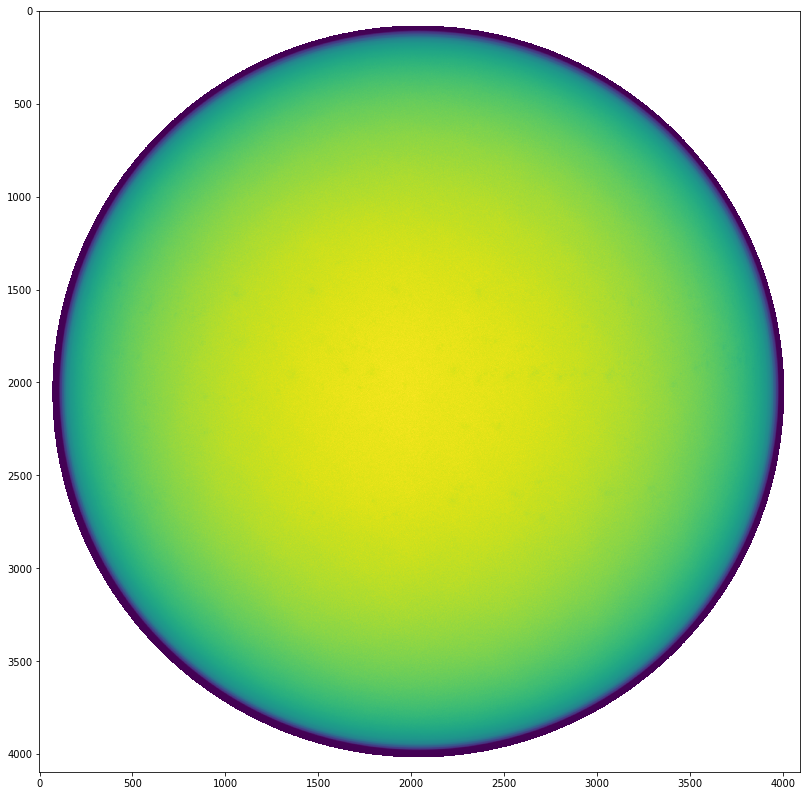

In [19]:
plt.figure(figsize=(14, 14))
plt.imshow(total_image)

In [20]:
normed_image = total_image / np.nanmedian(total_image)

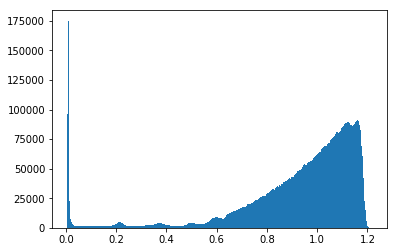

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


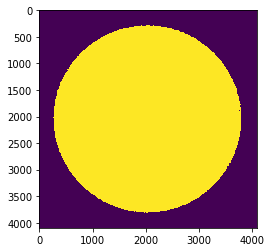

In [33]:
plt.hist(normed_image.ravel(), 500);
plt.show()
on_sun_mask = normed_image > 0.8
plt.imshow(on_sun_mask)

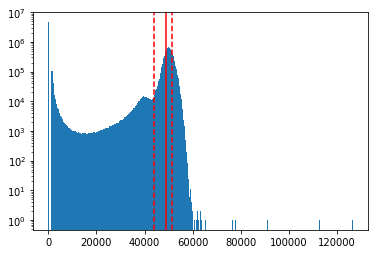

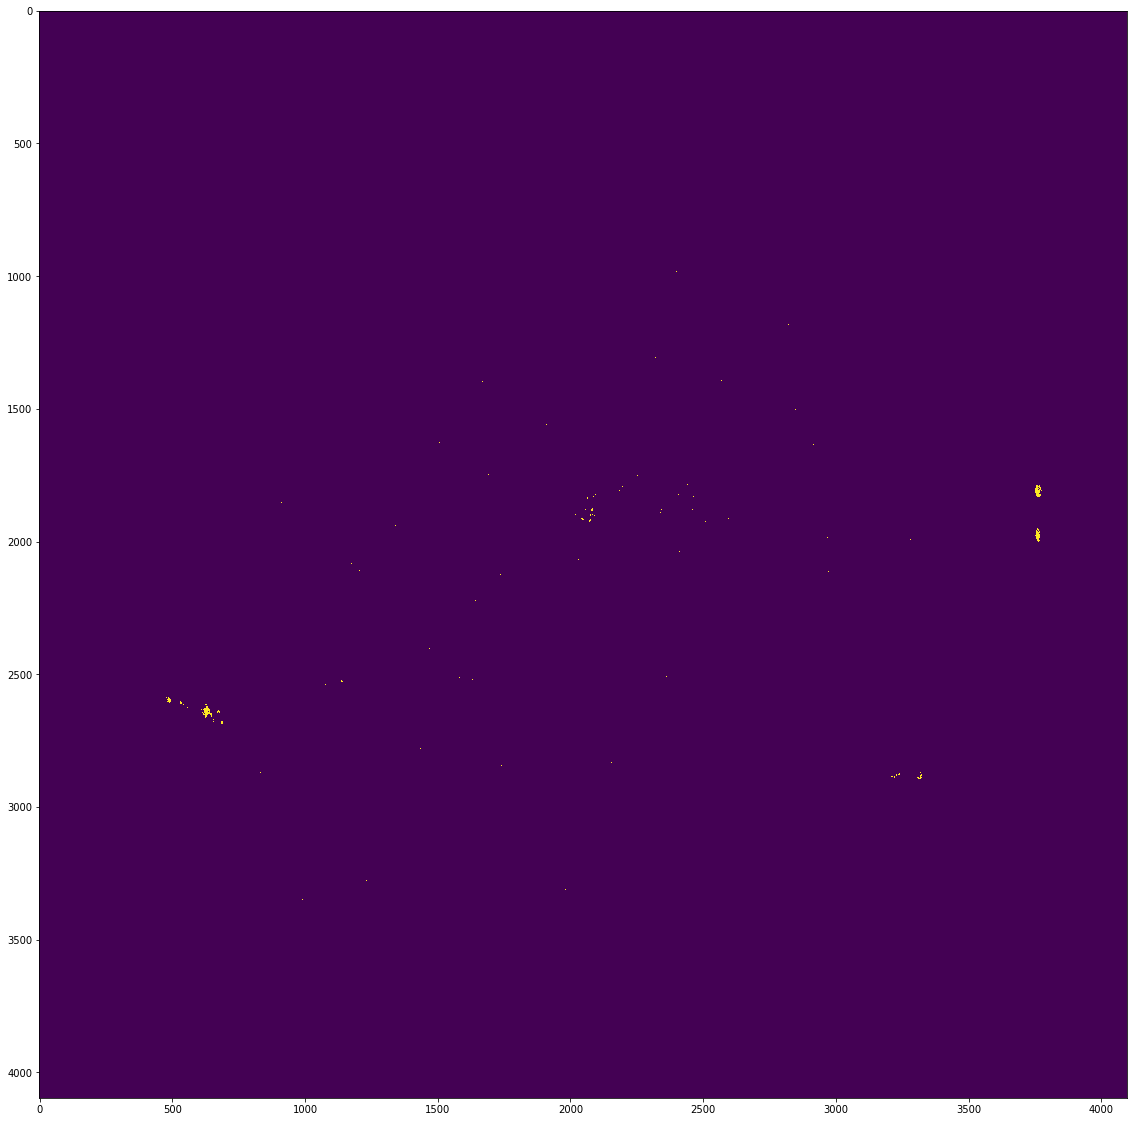

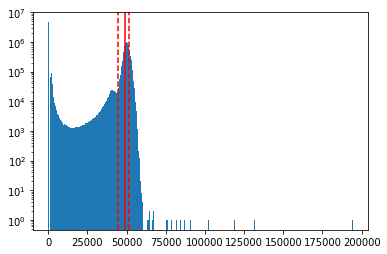

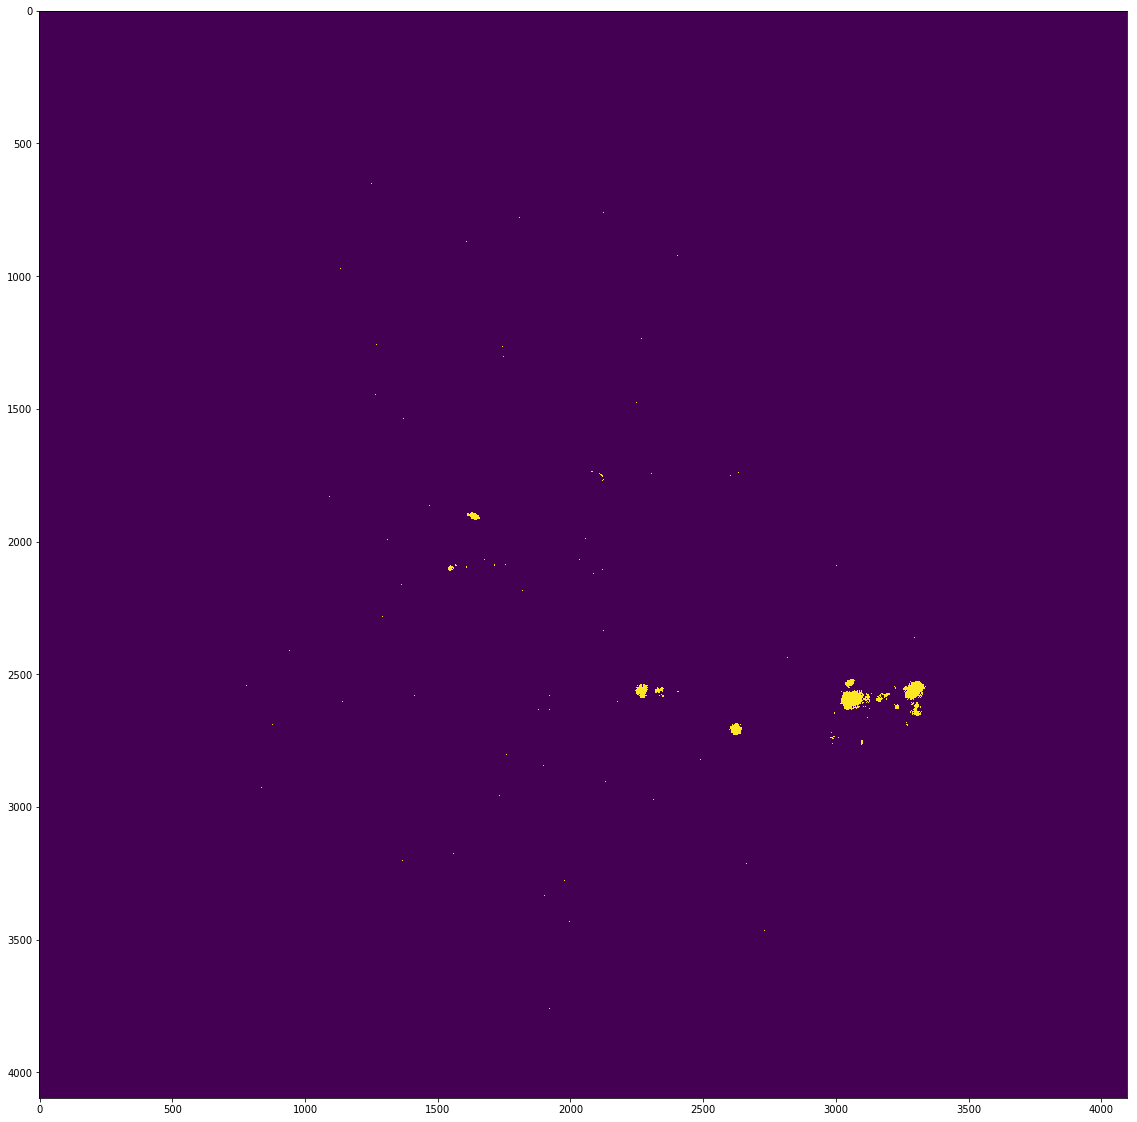

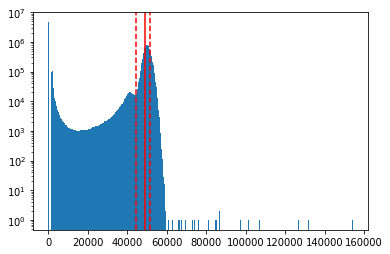

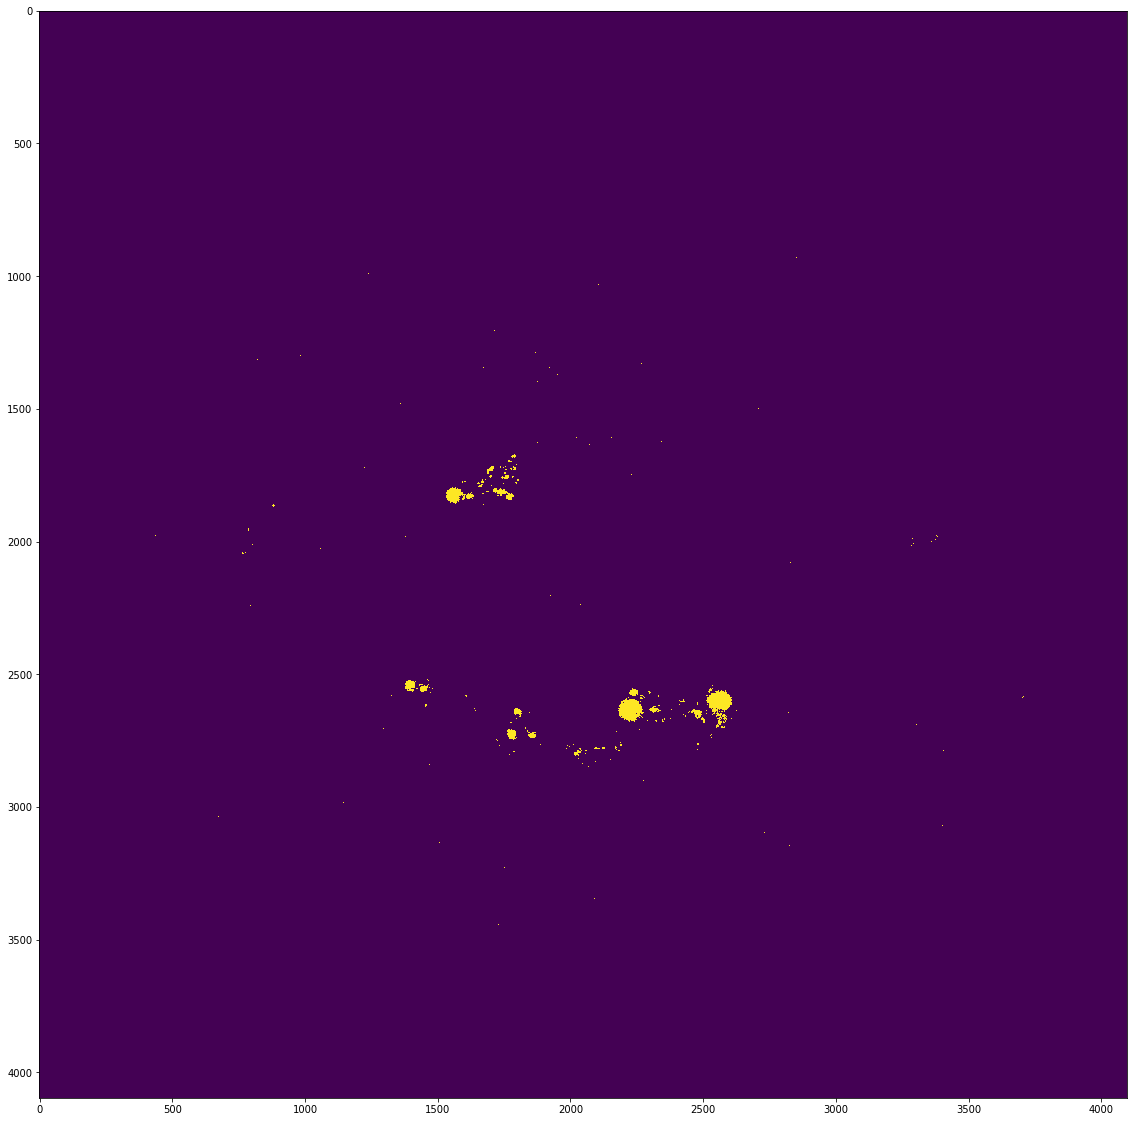

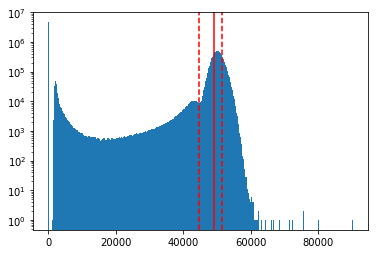

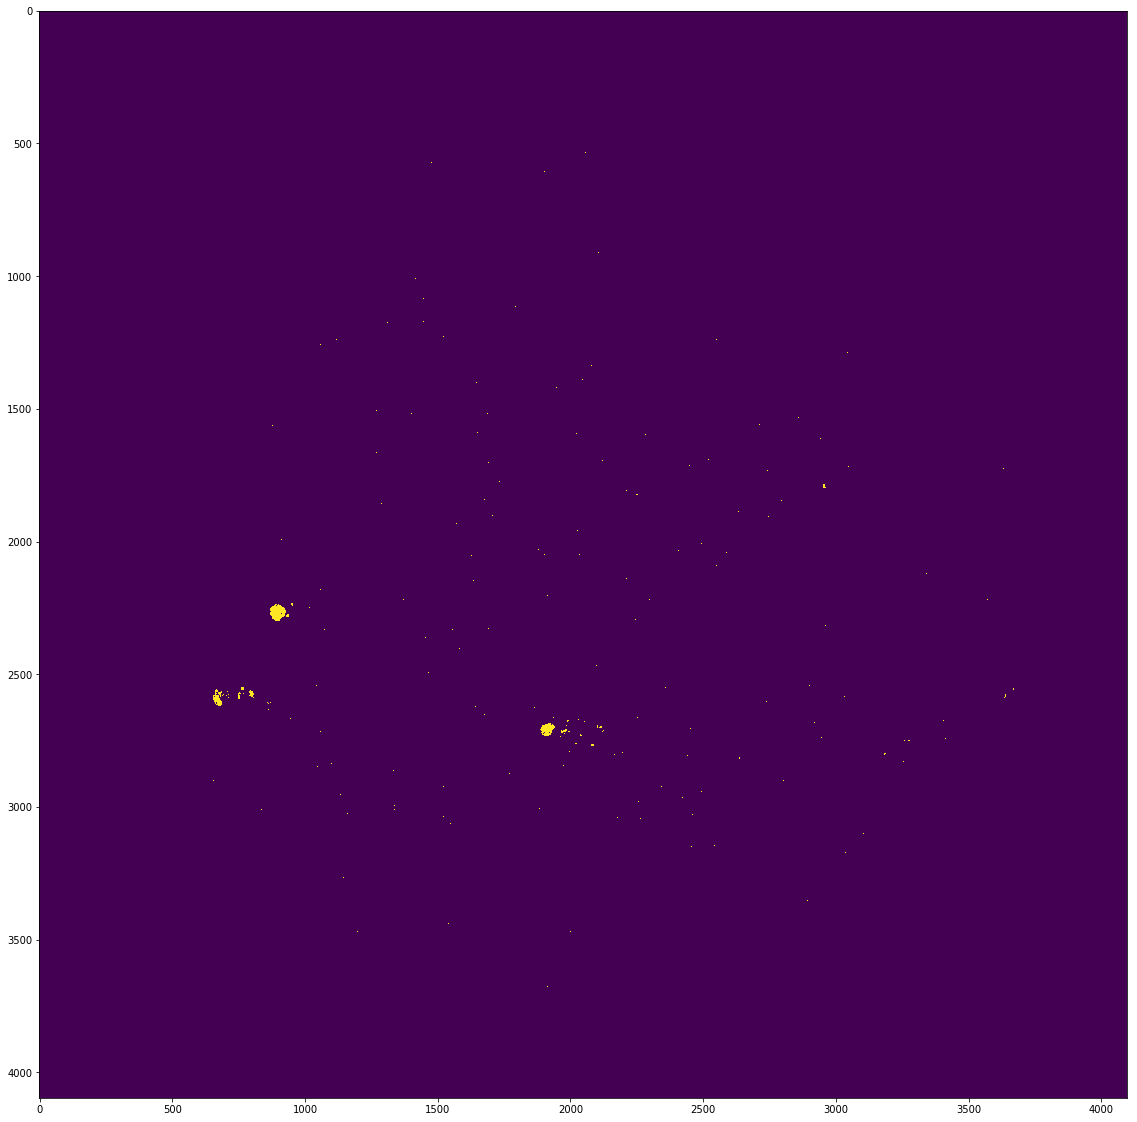

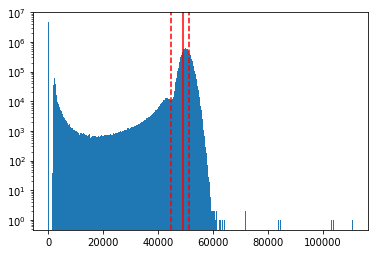

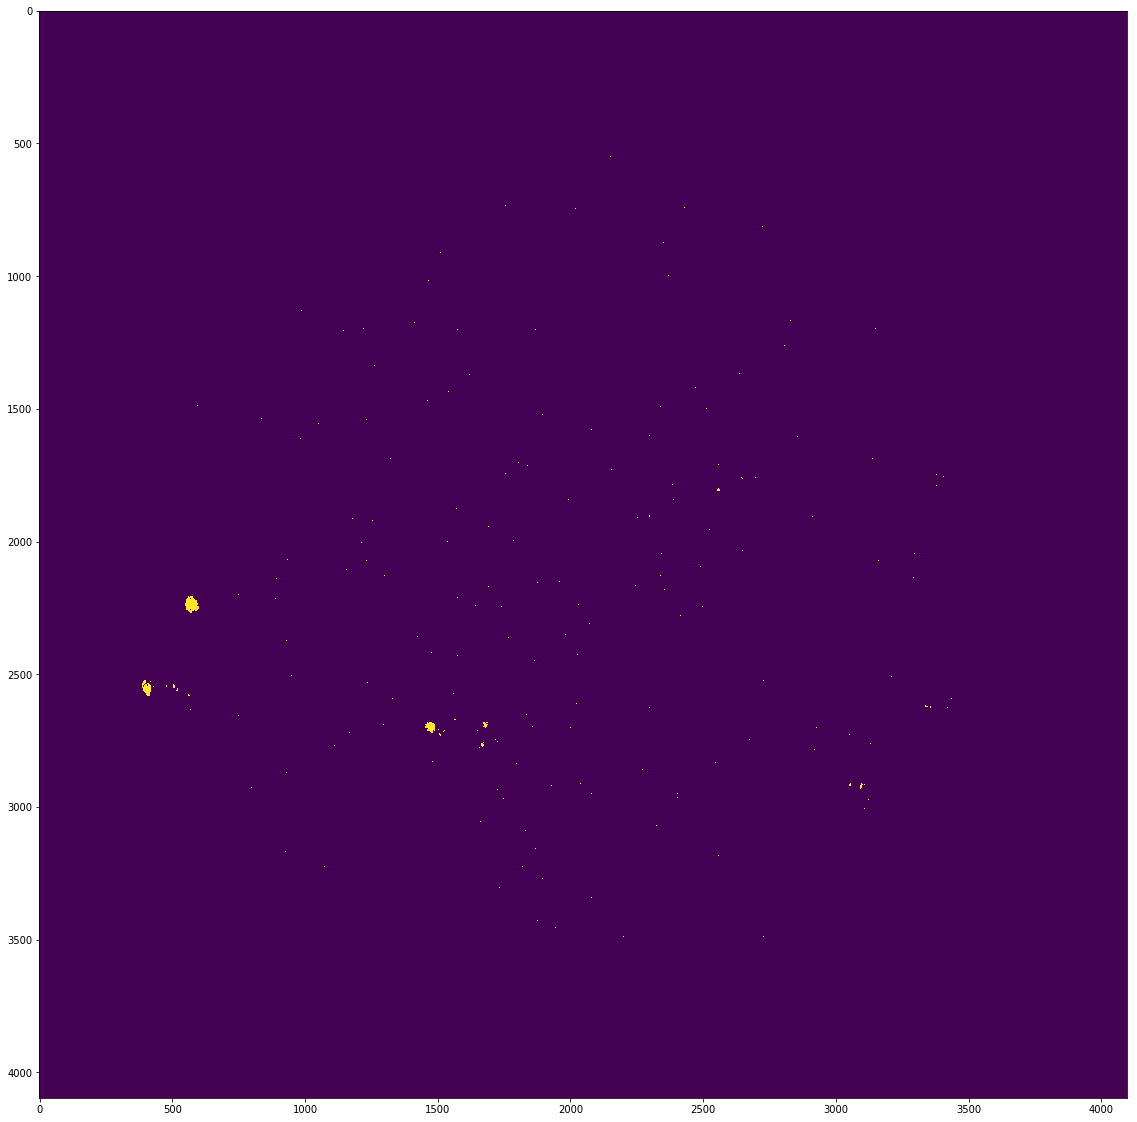

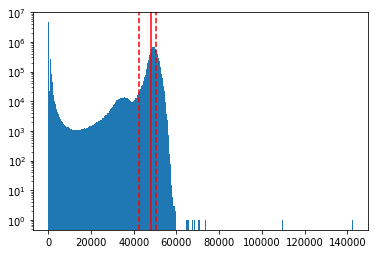

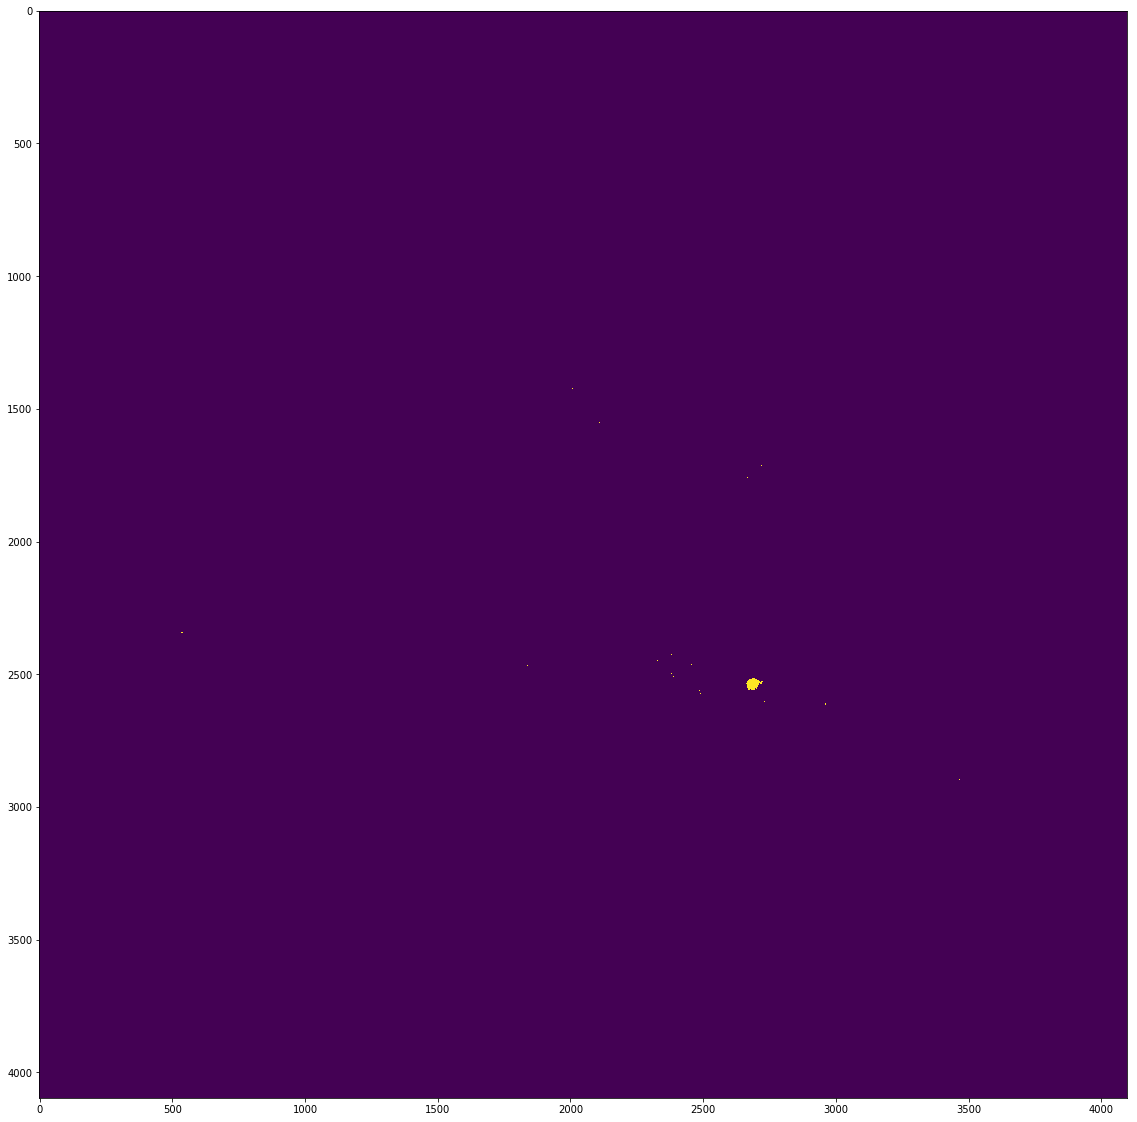

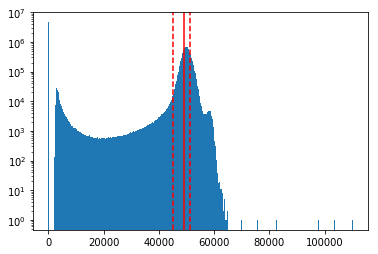

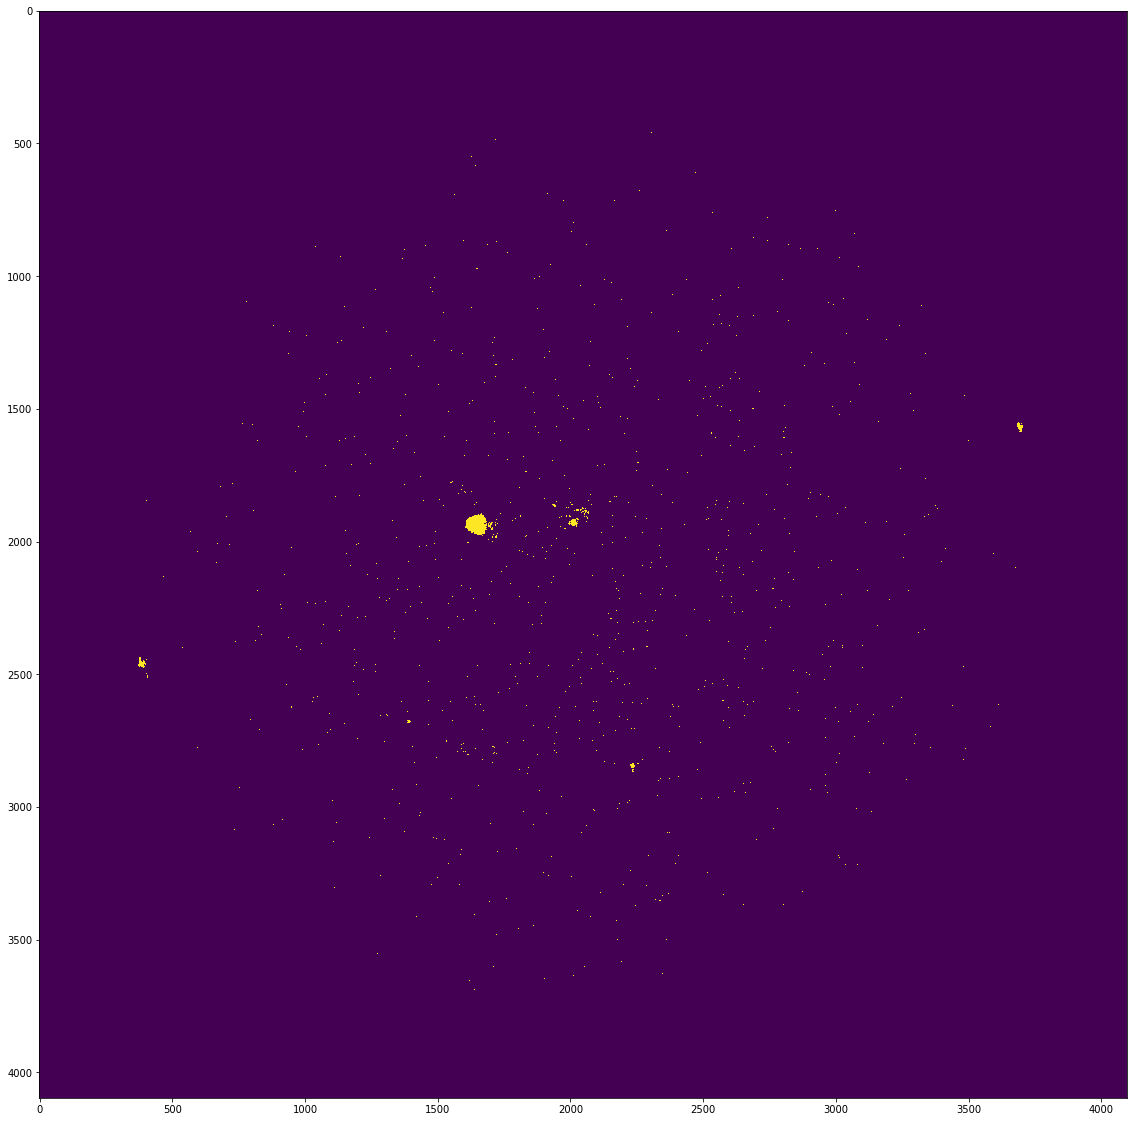

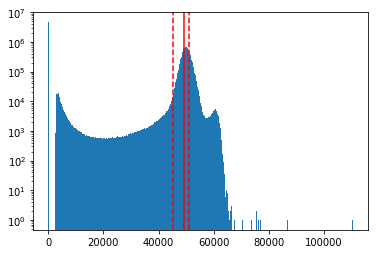

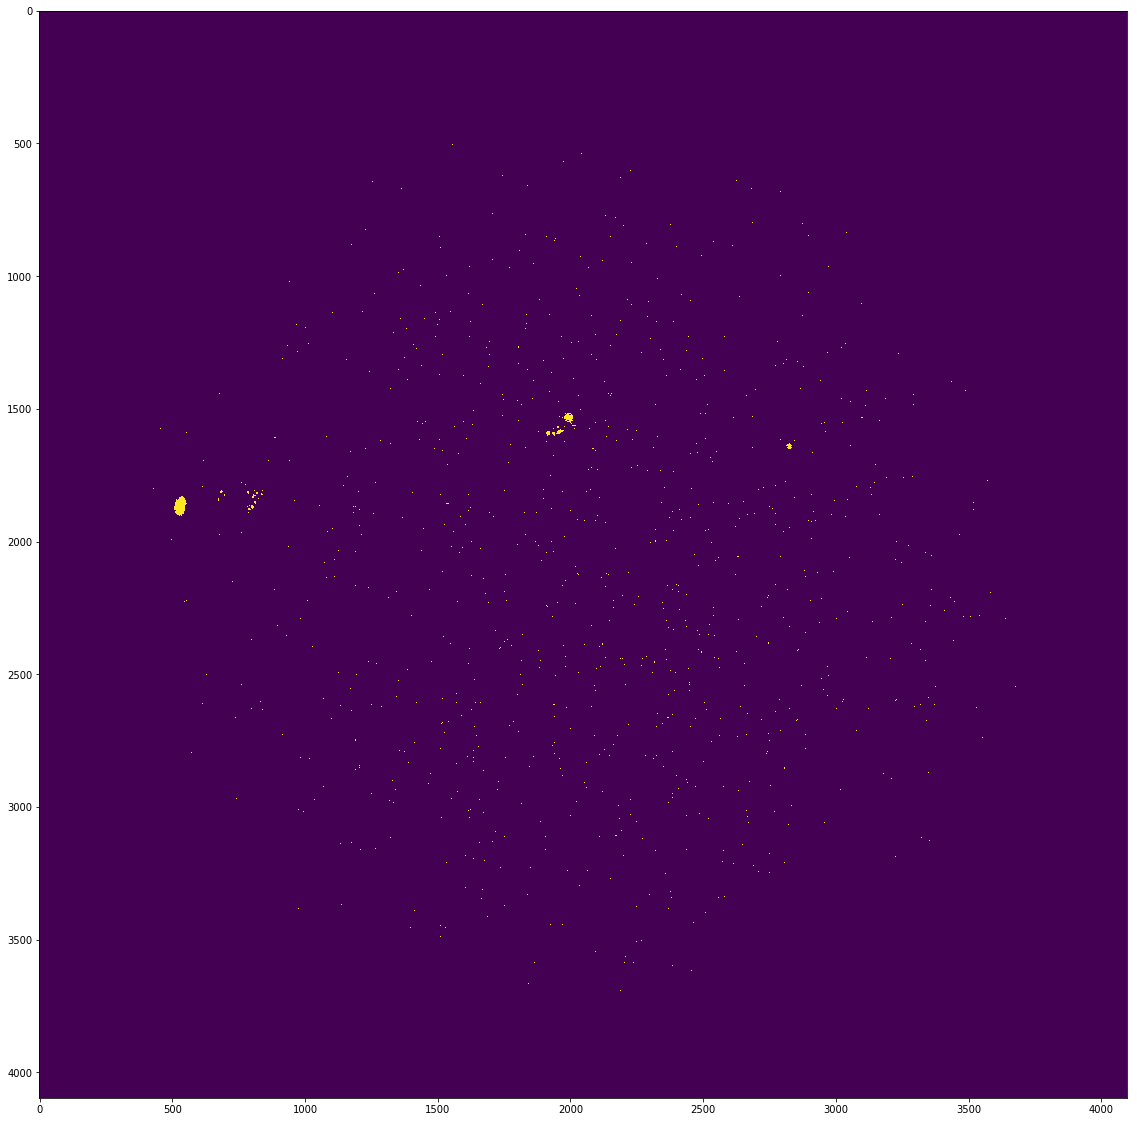

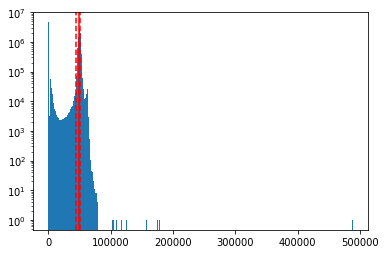

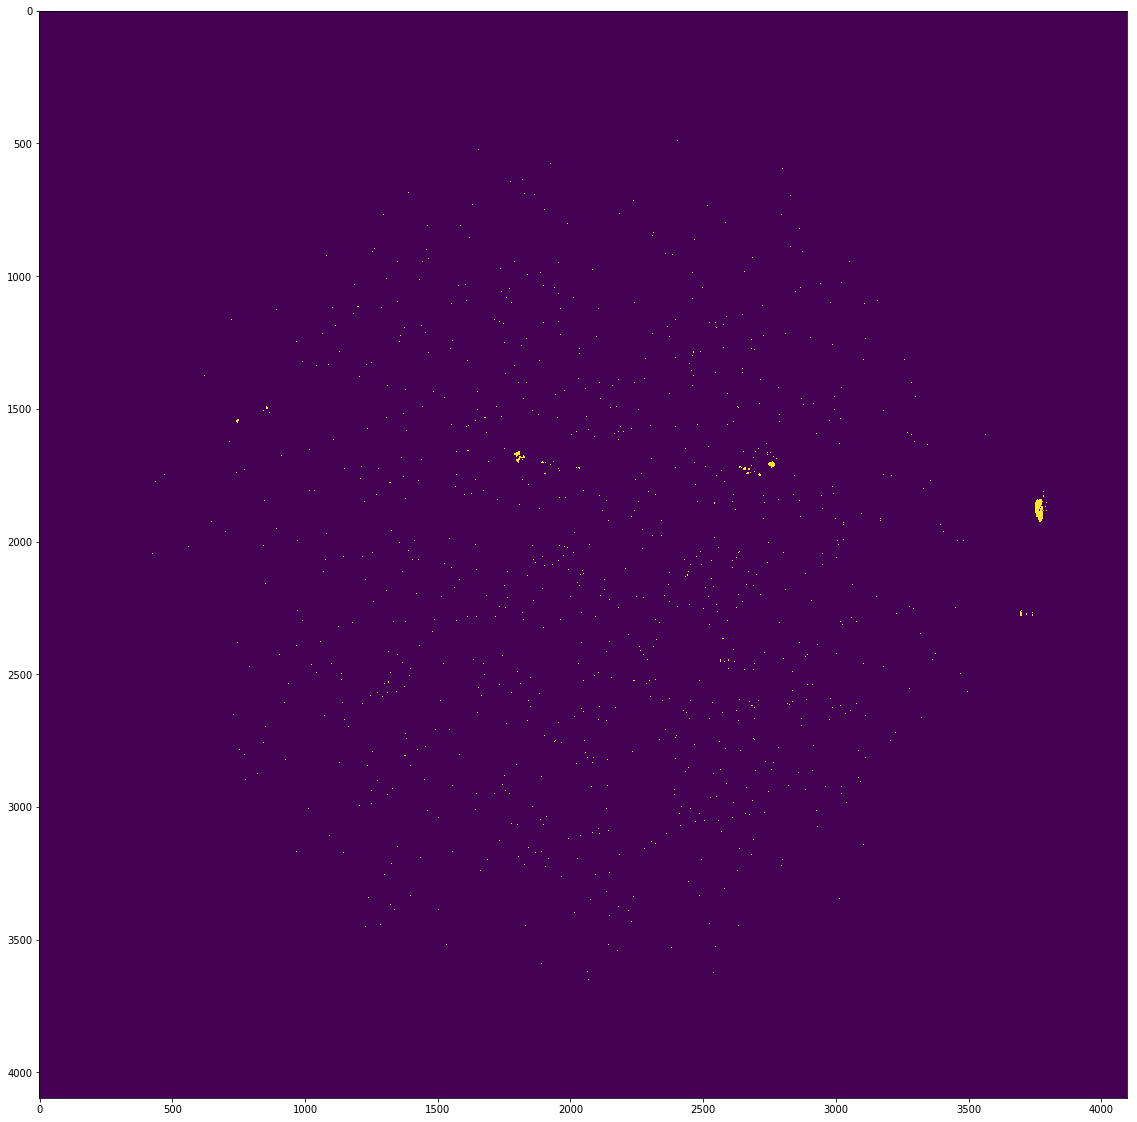

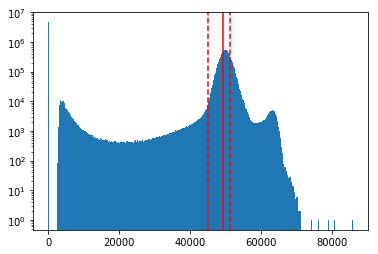

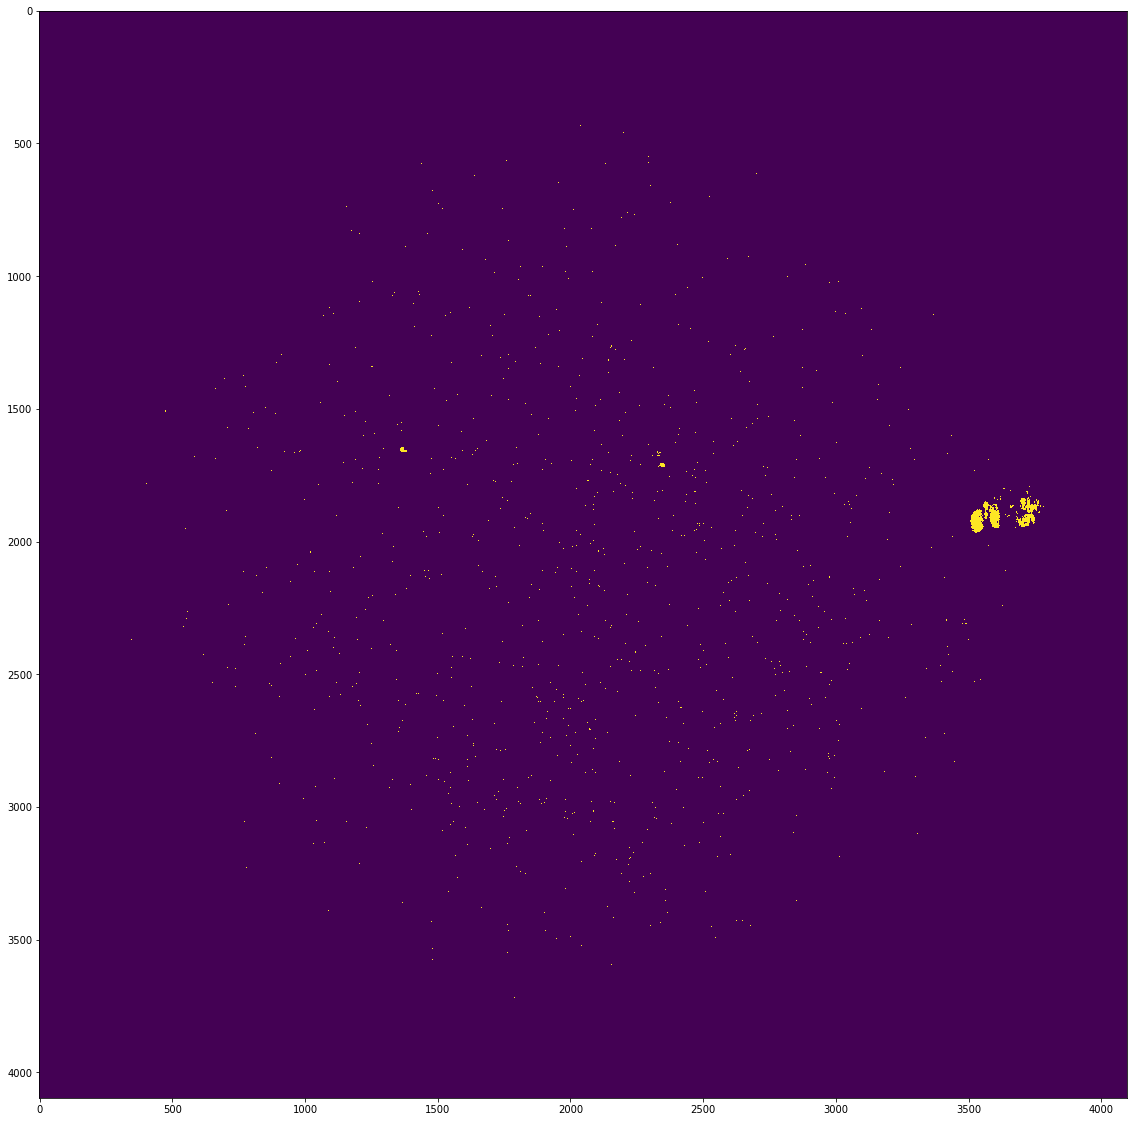

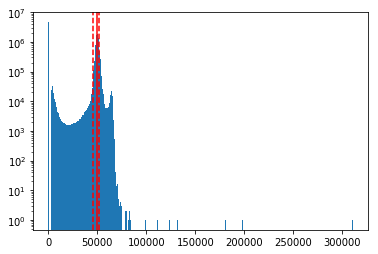

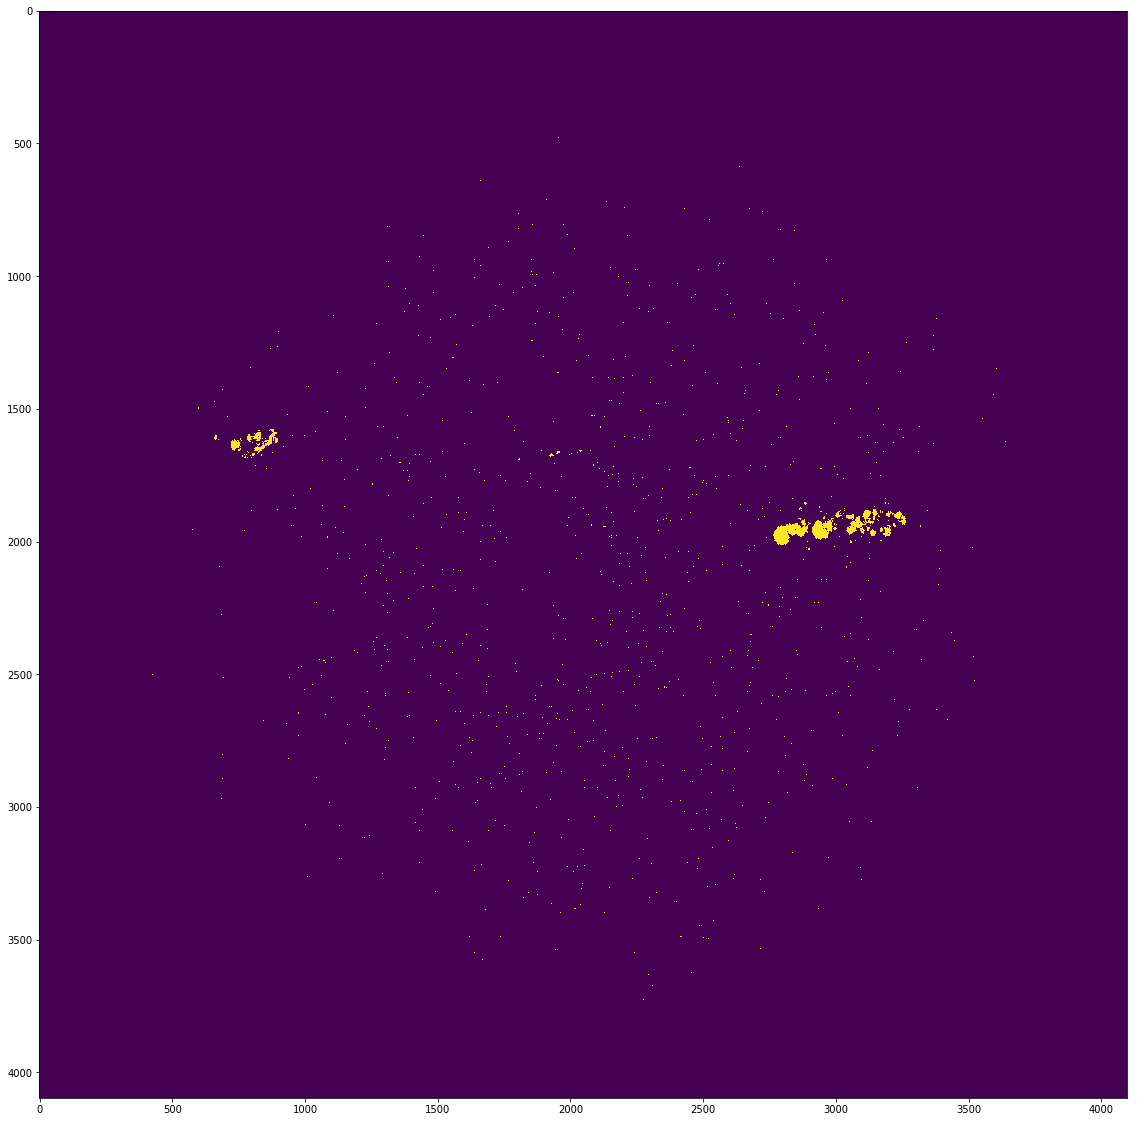

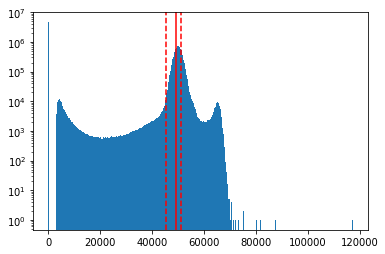

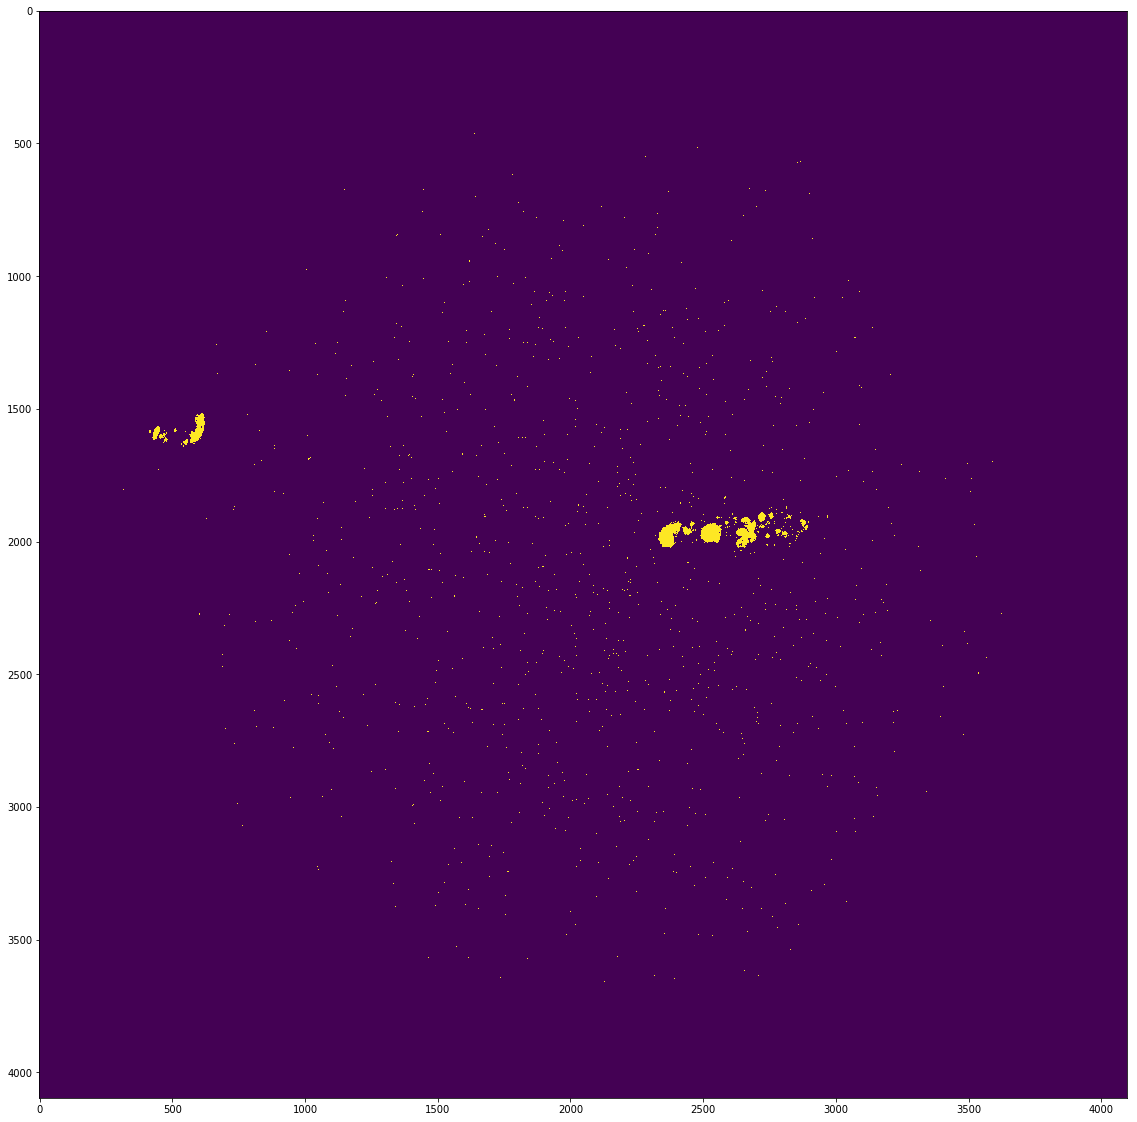

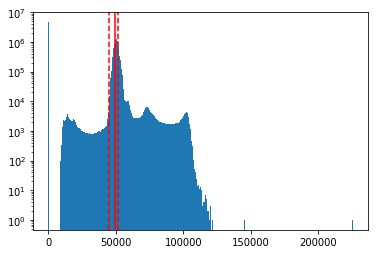

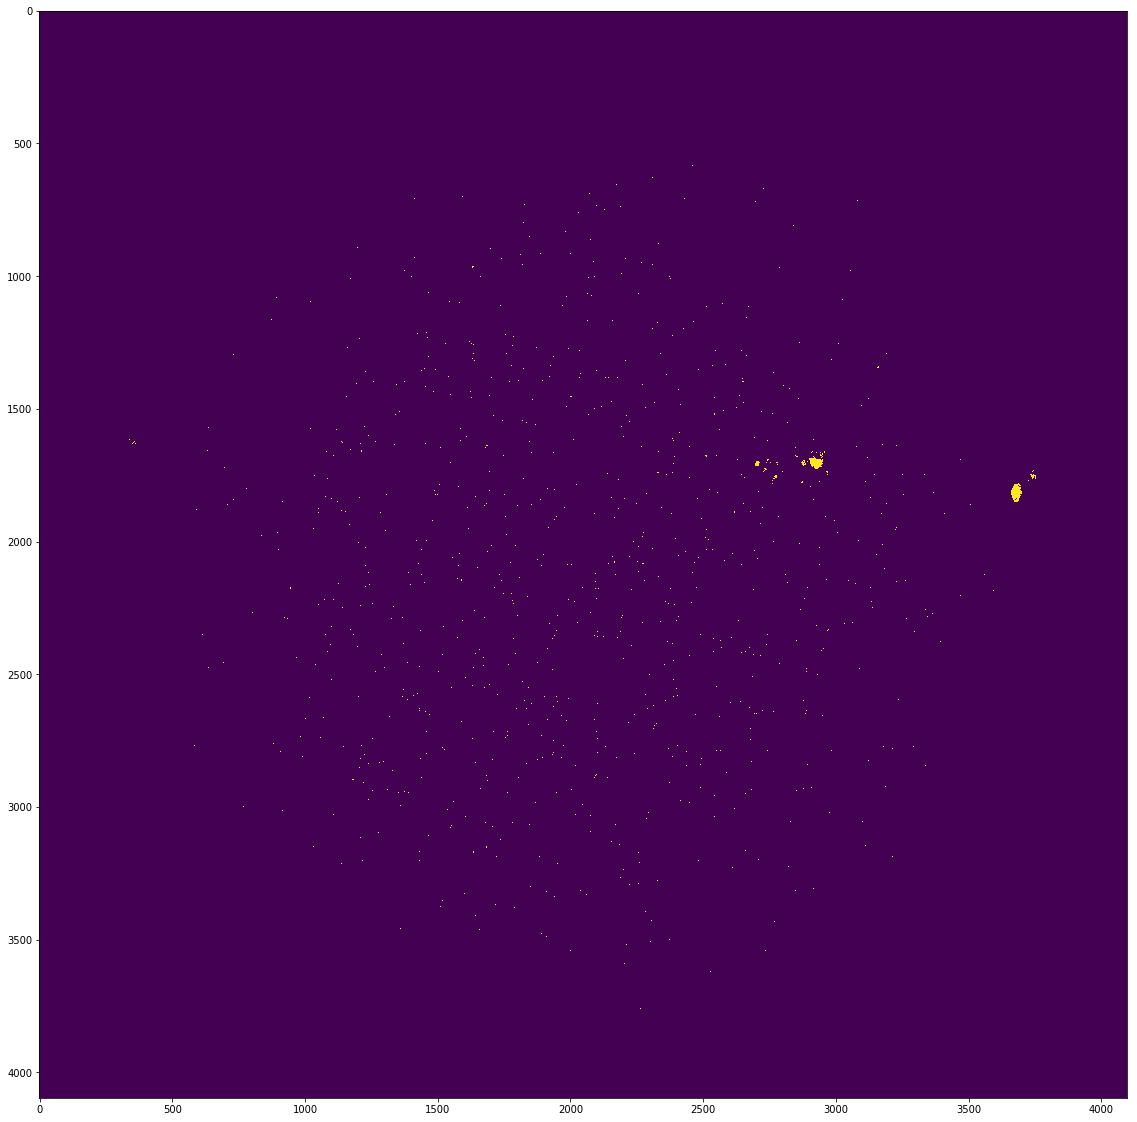

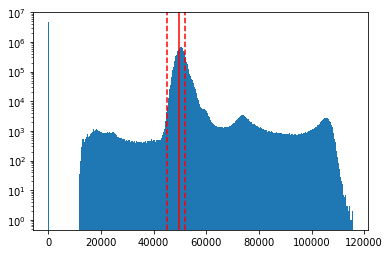

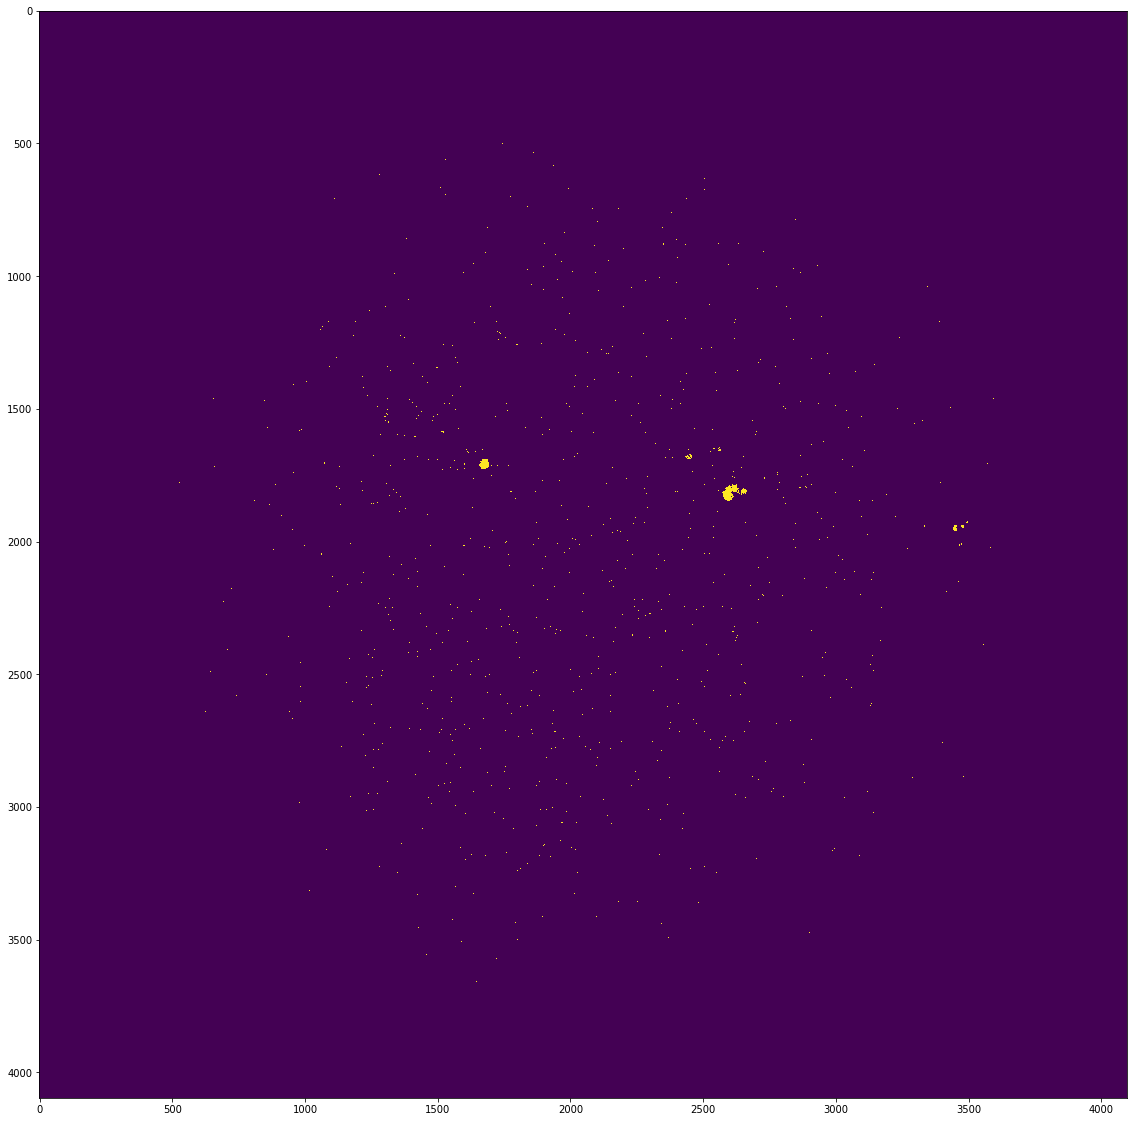

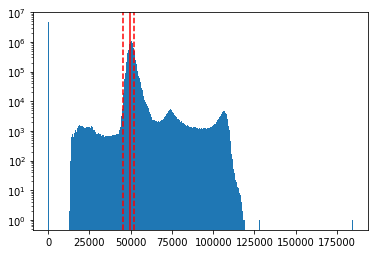

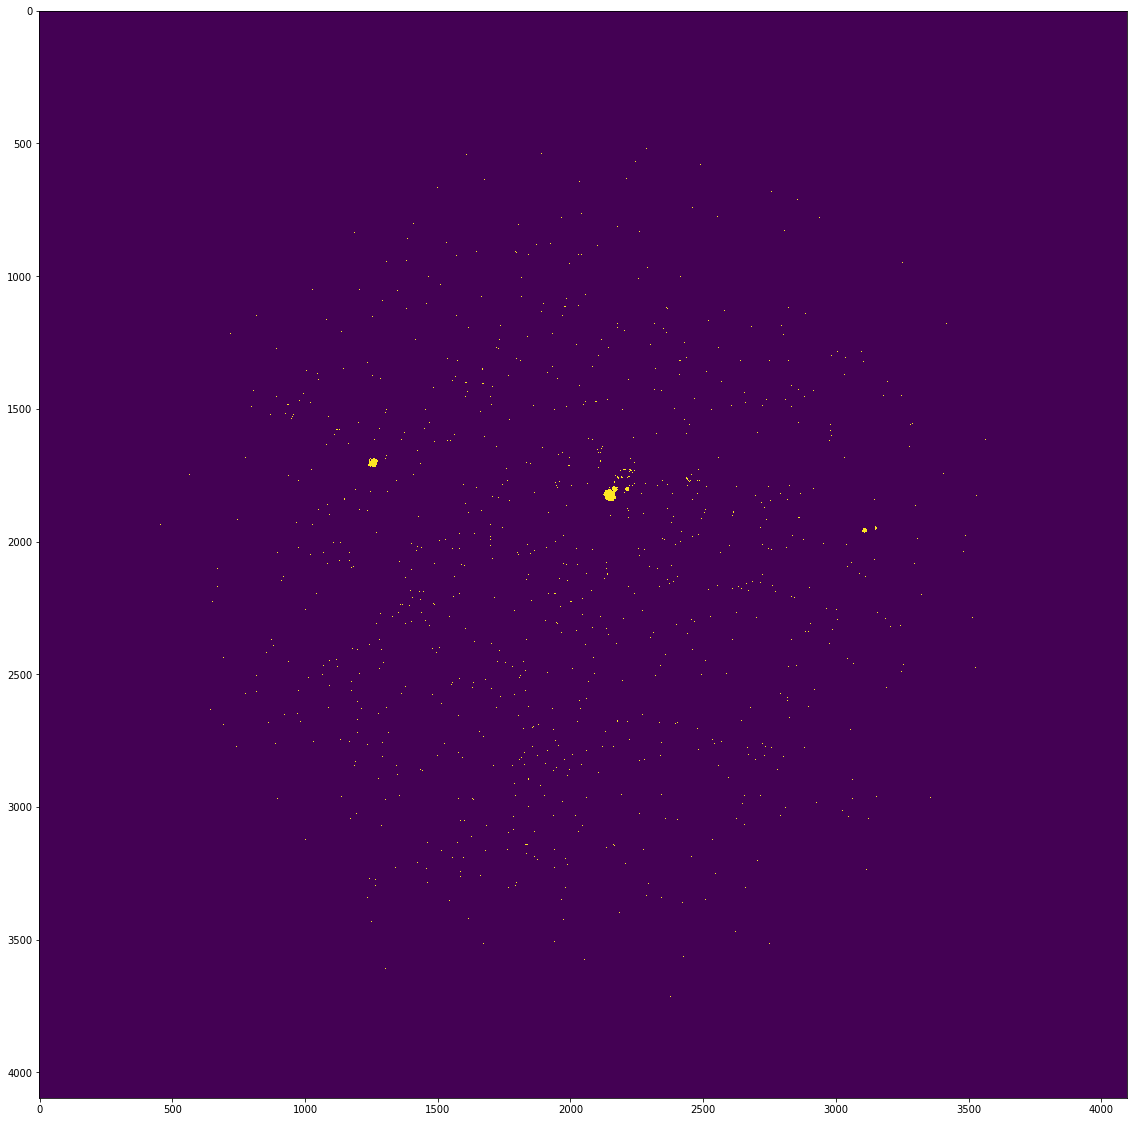

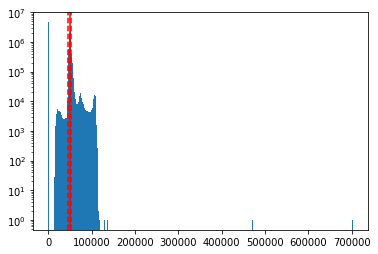

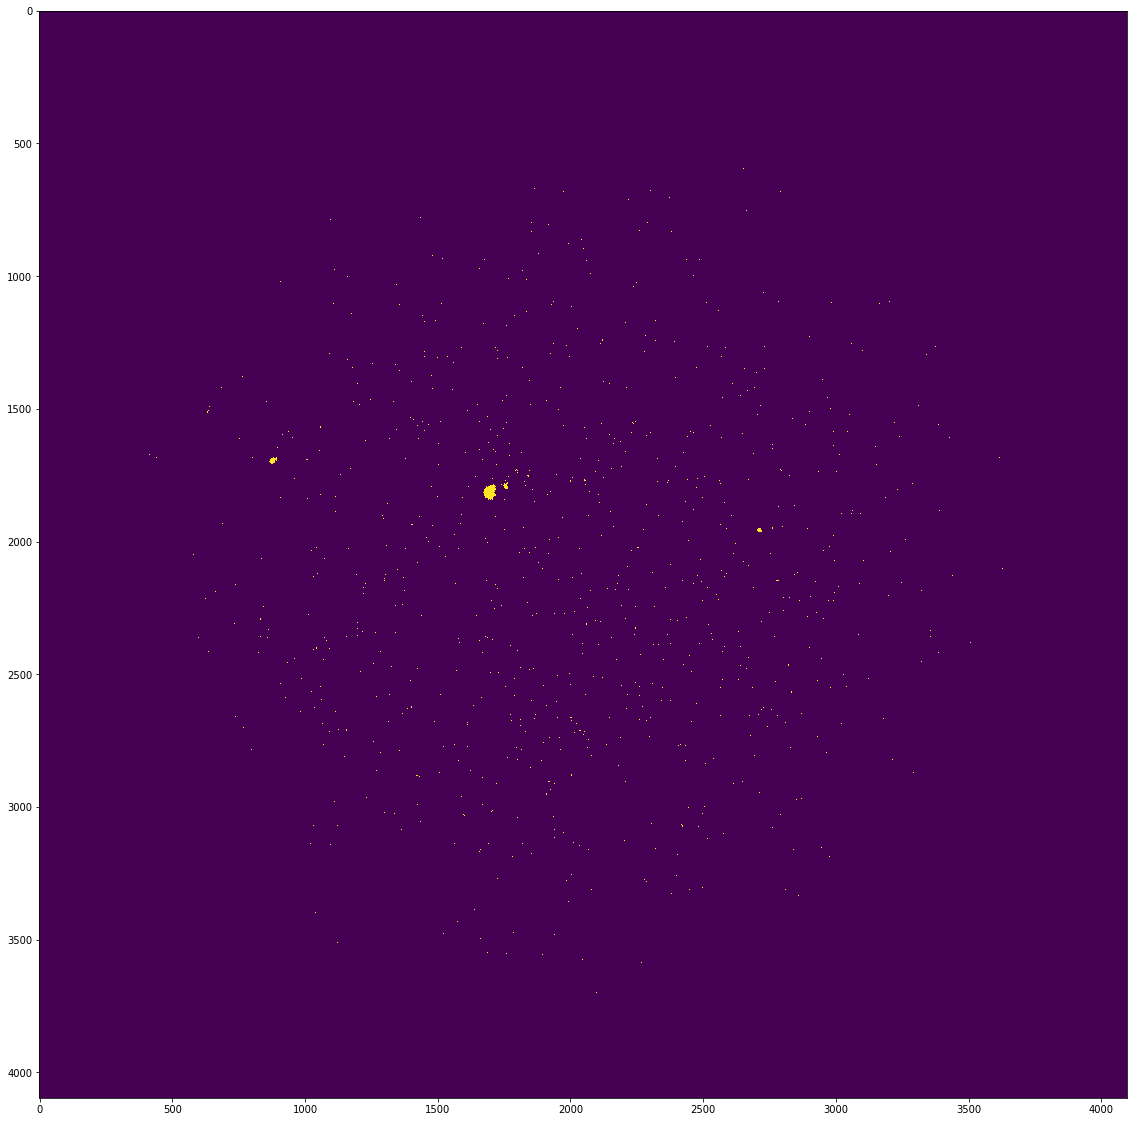

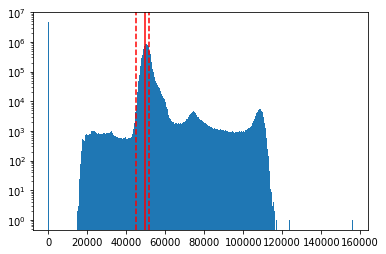

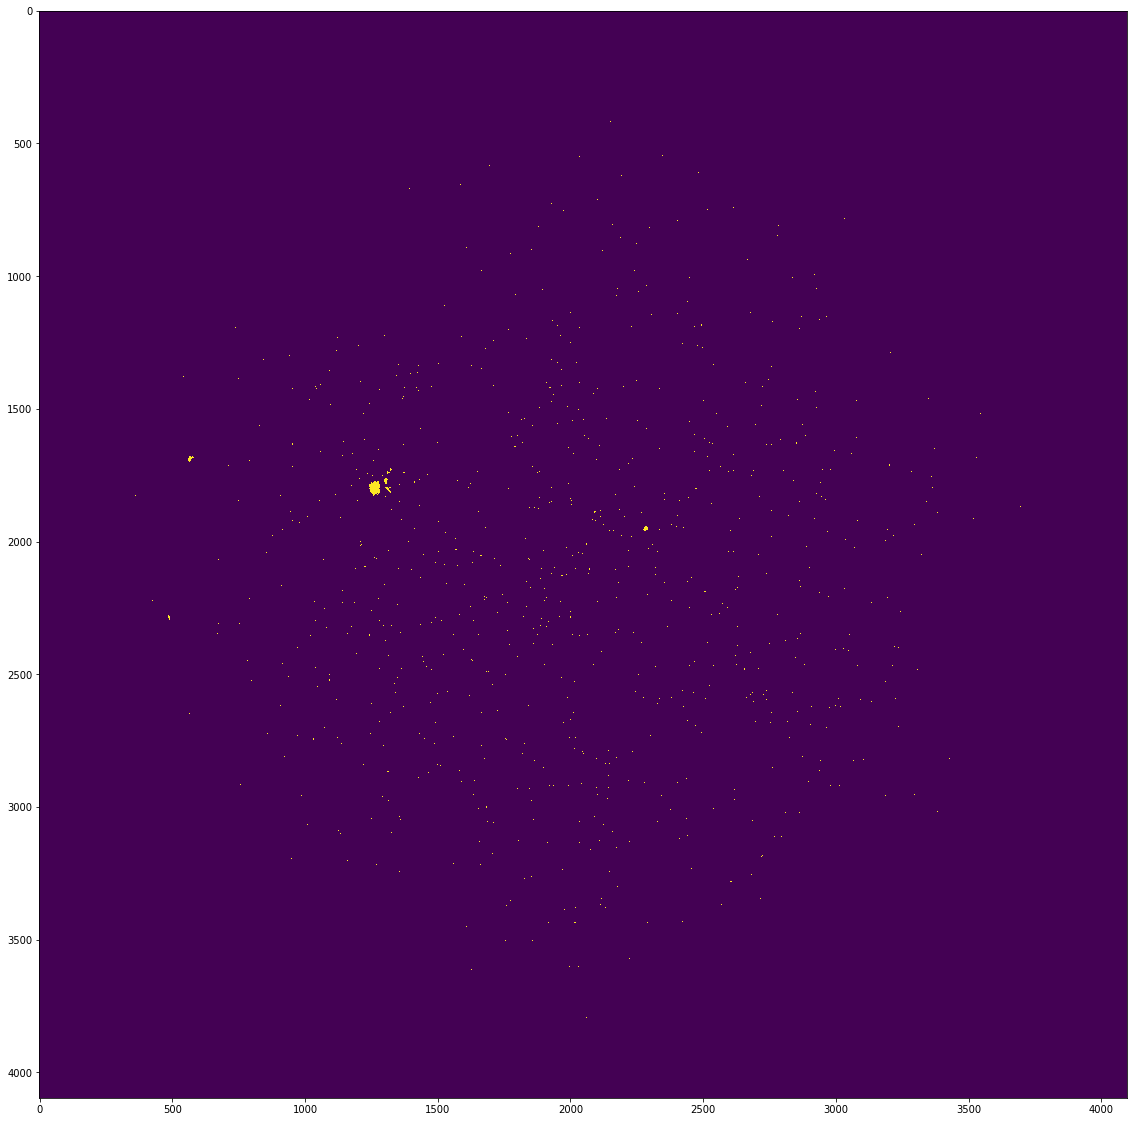

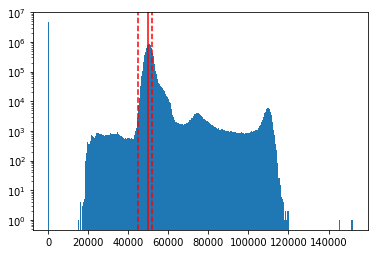

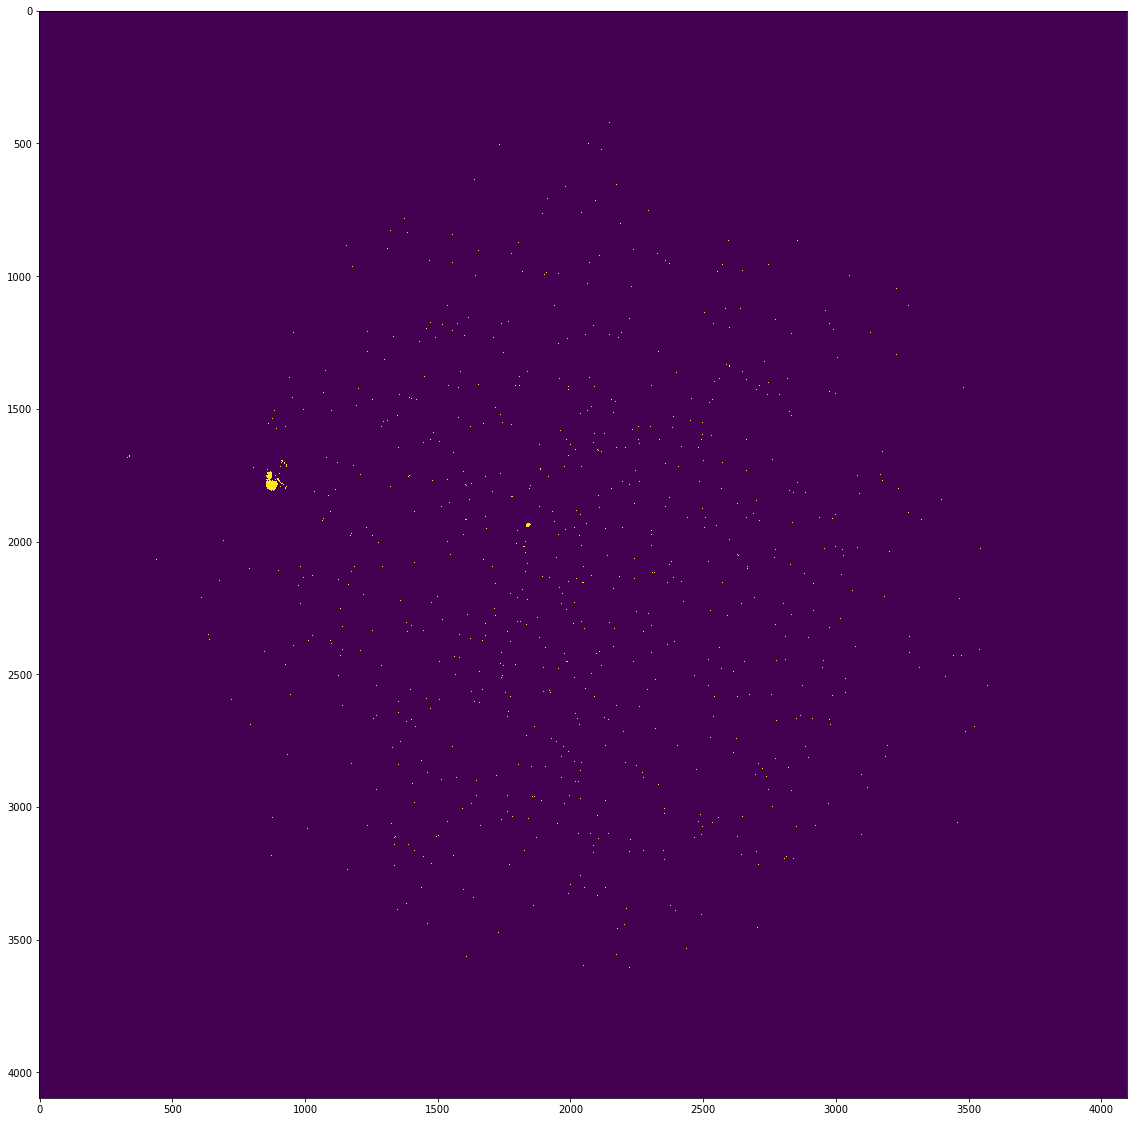

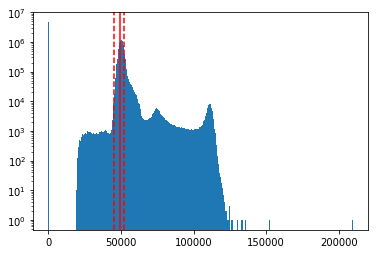

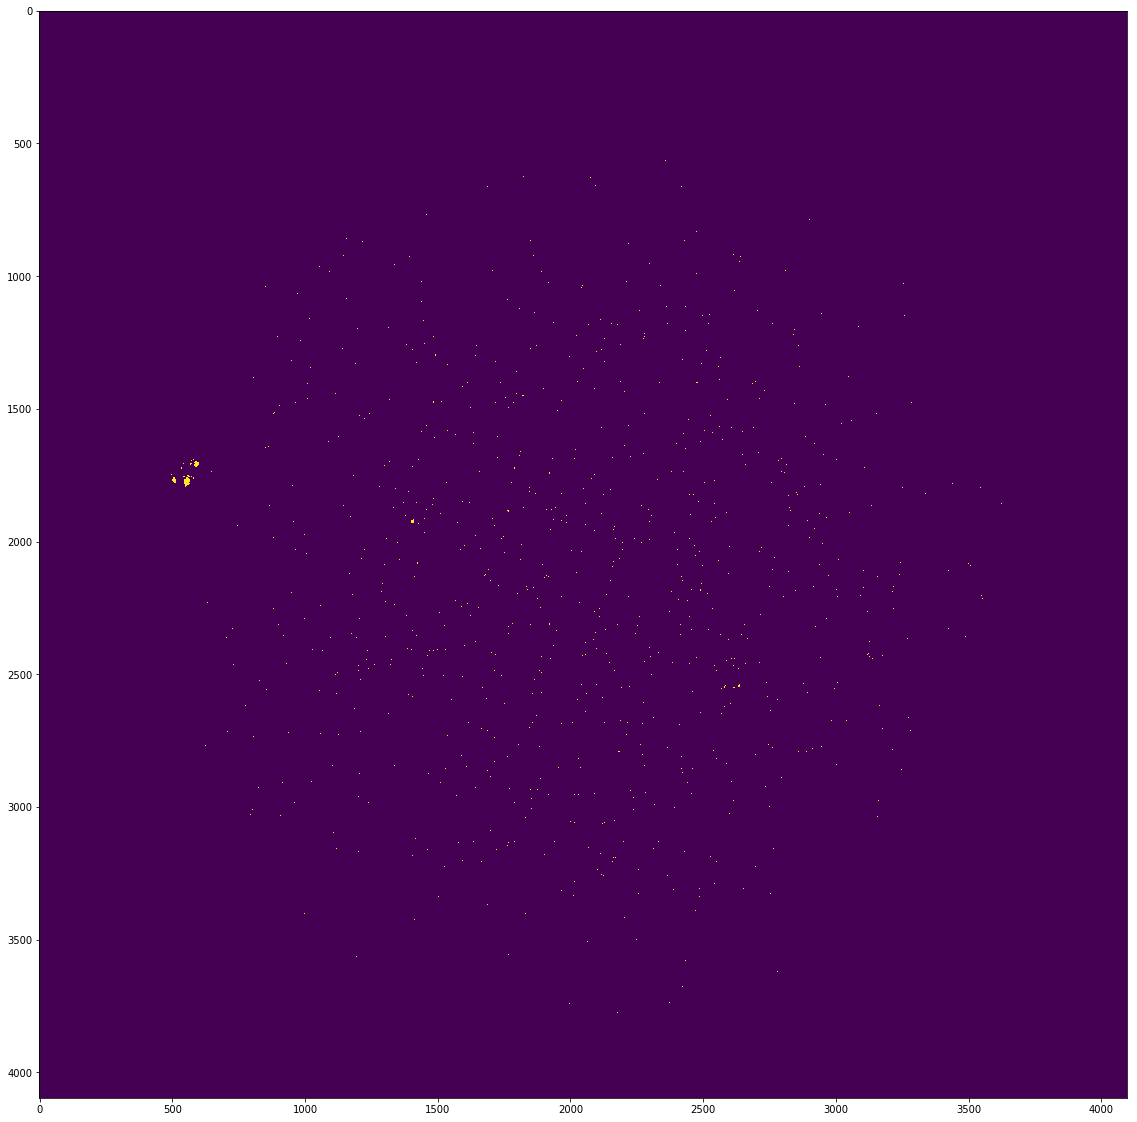

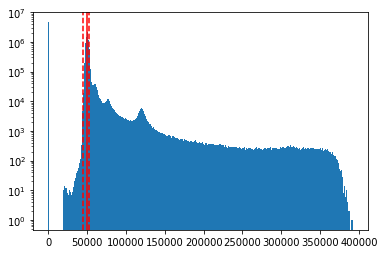

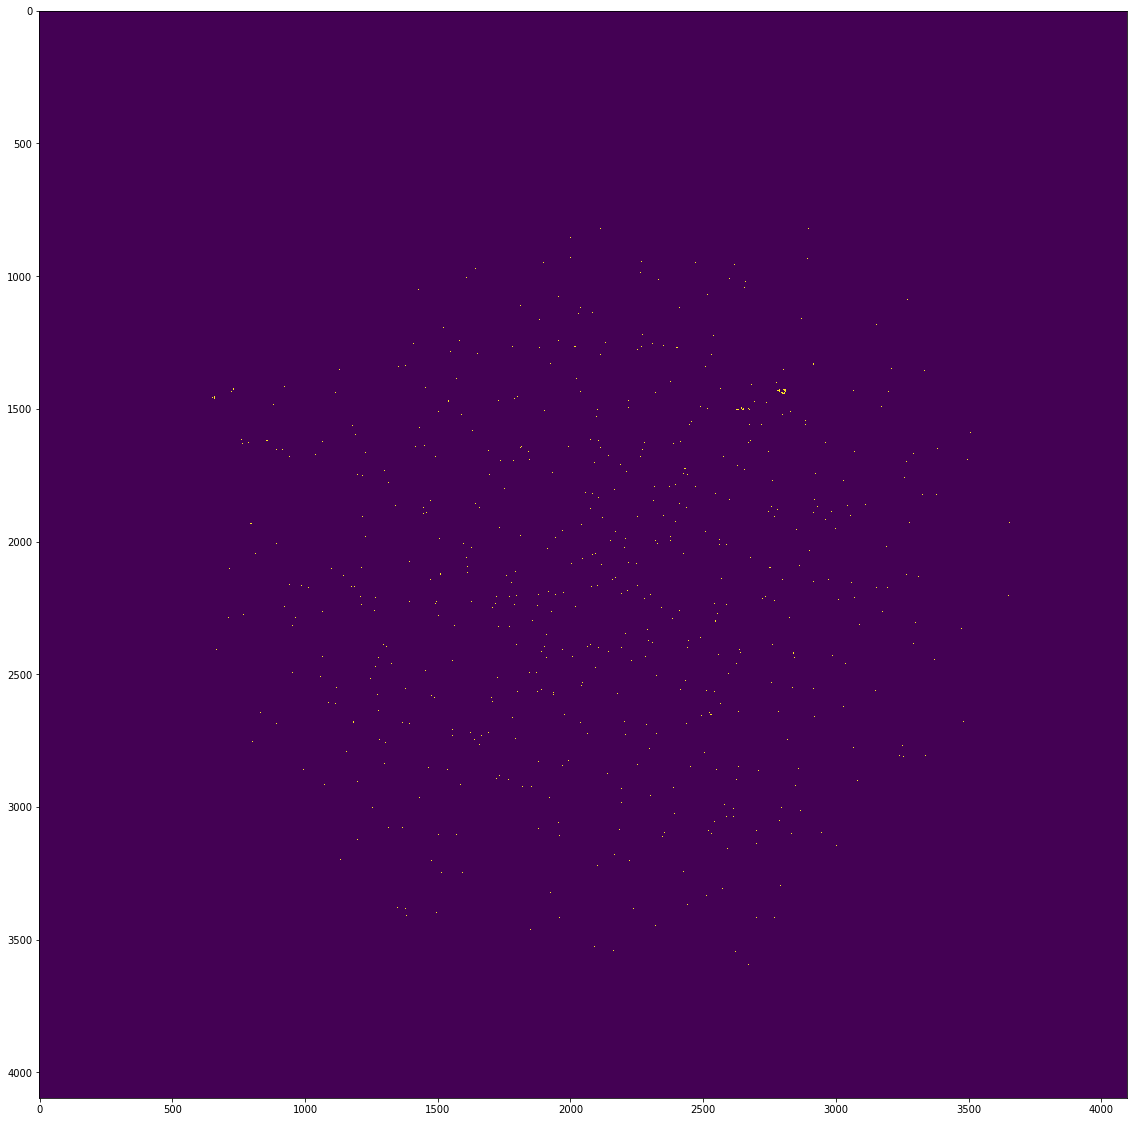

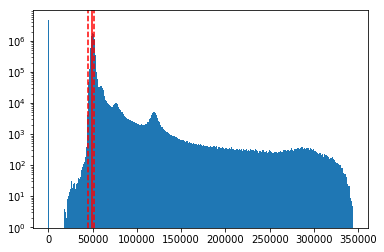

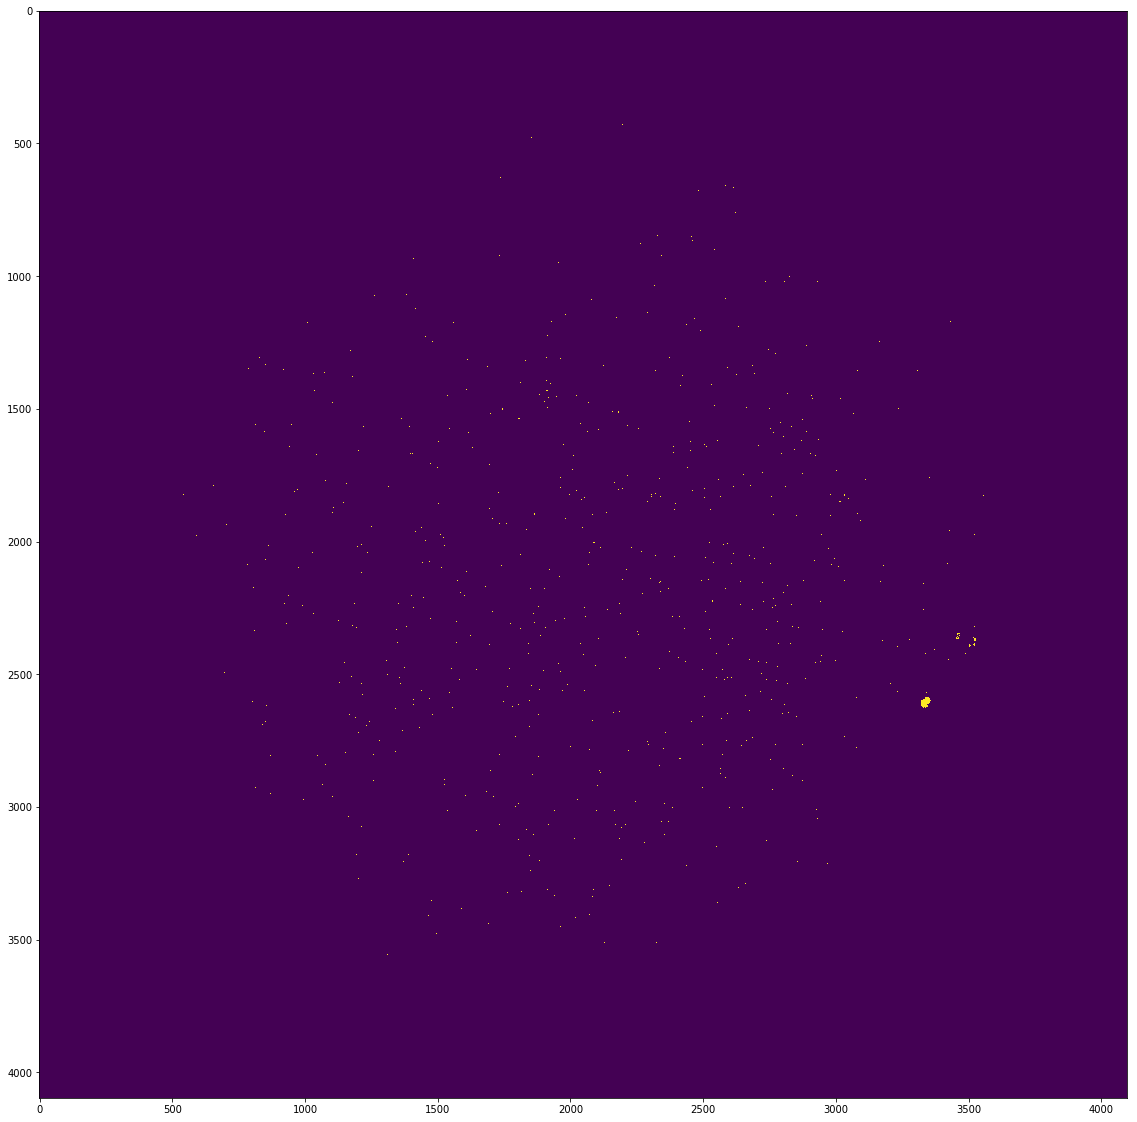

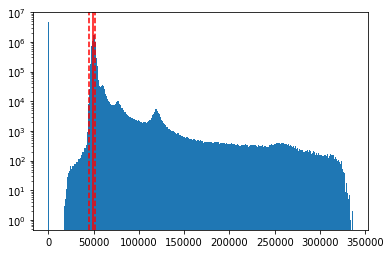

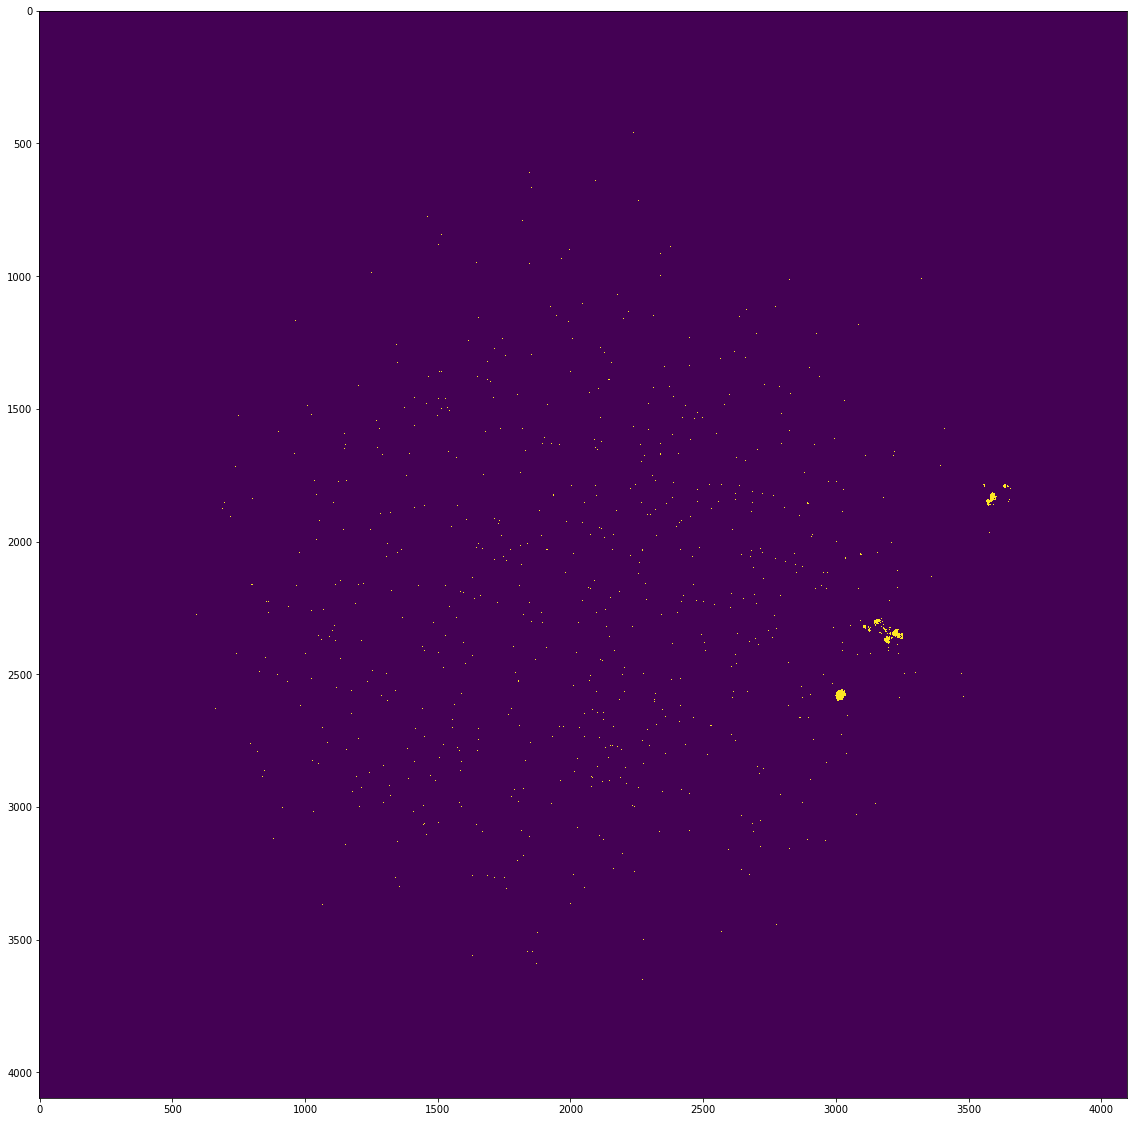

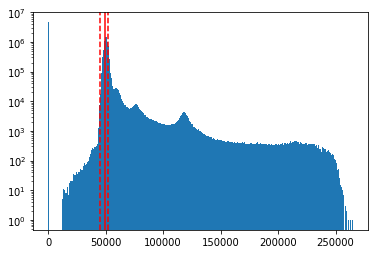

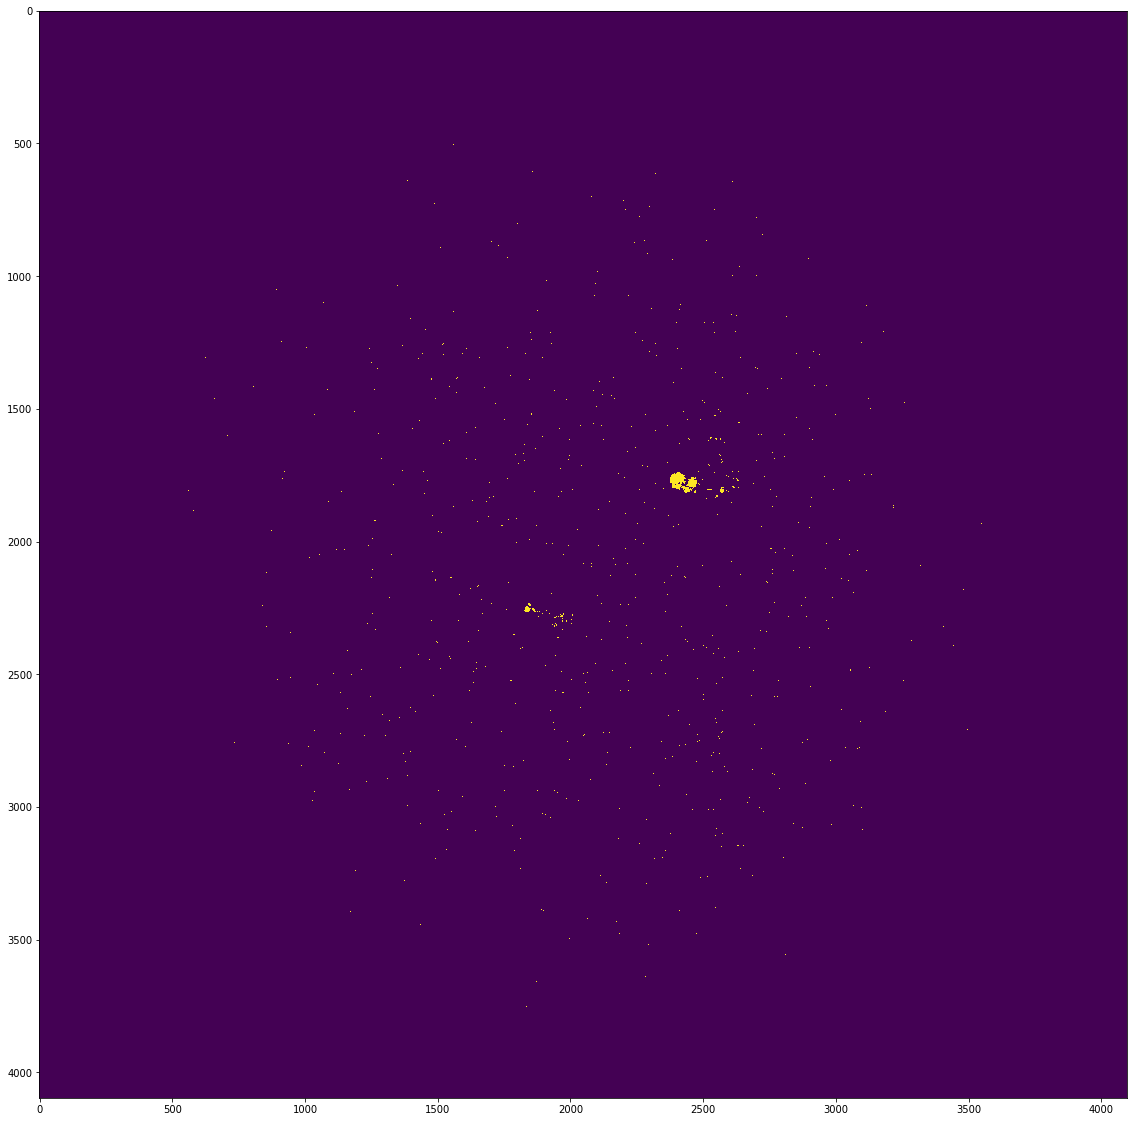

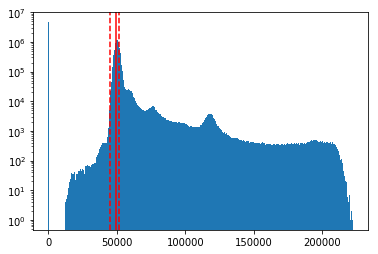

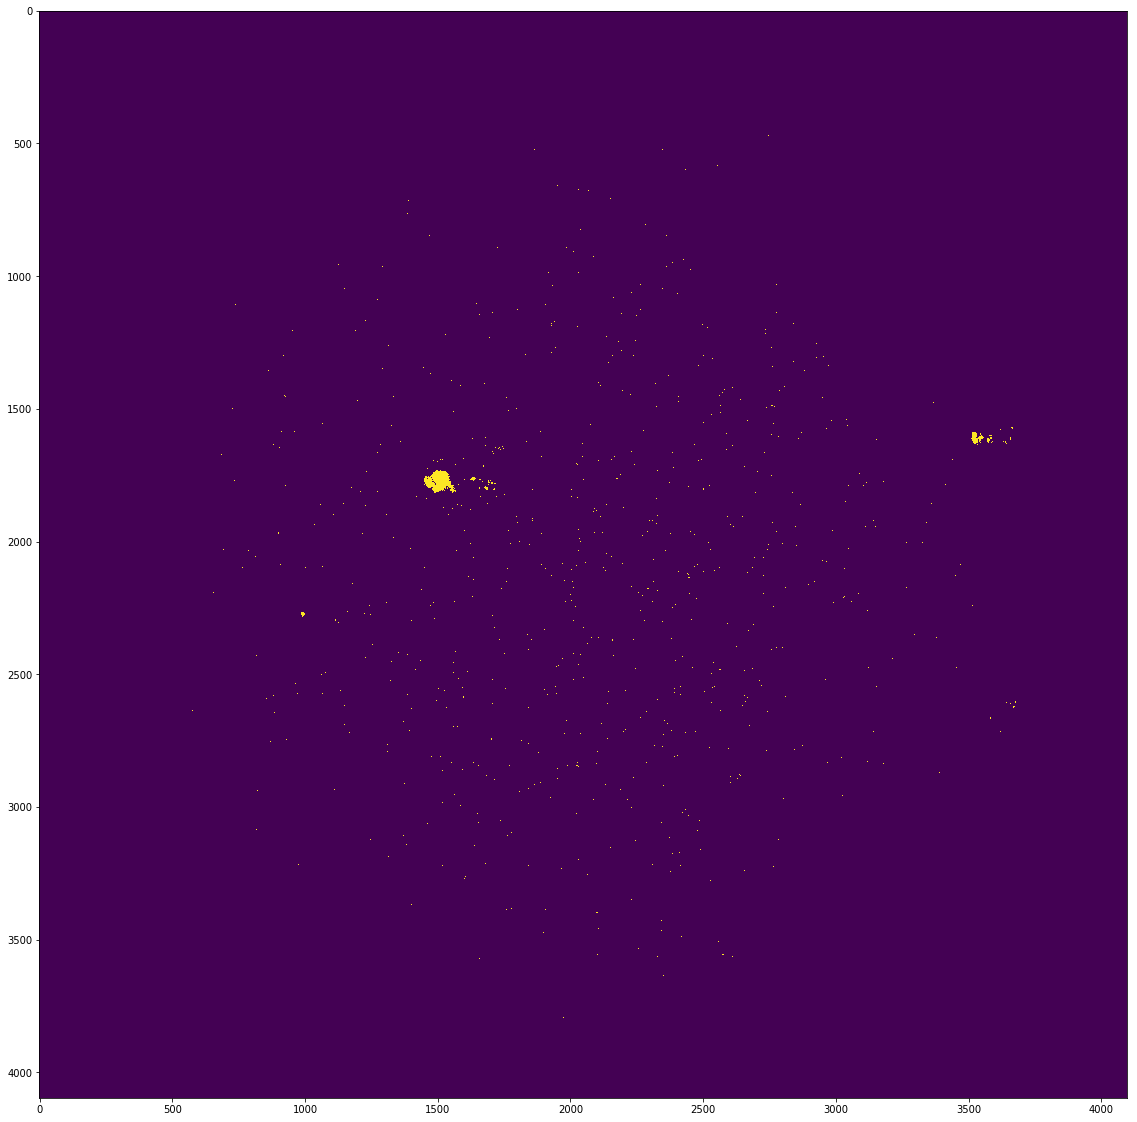

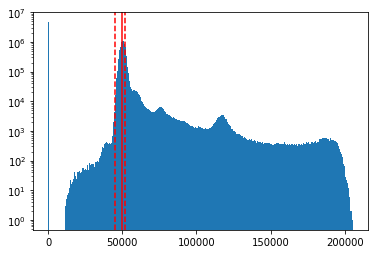

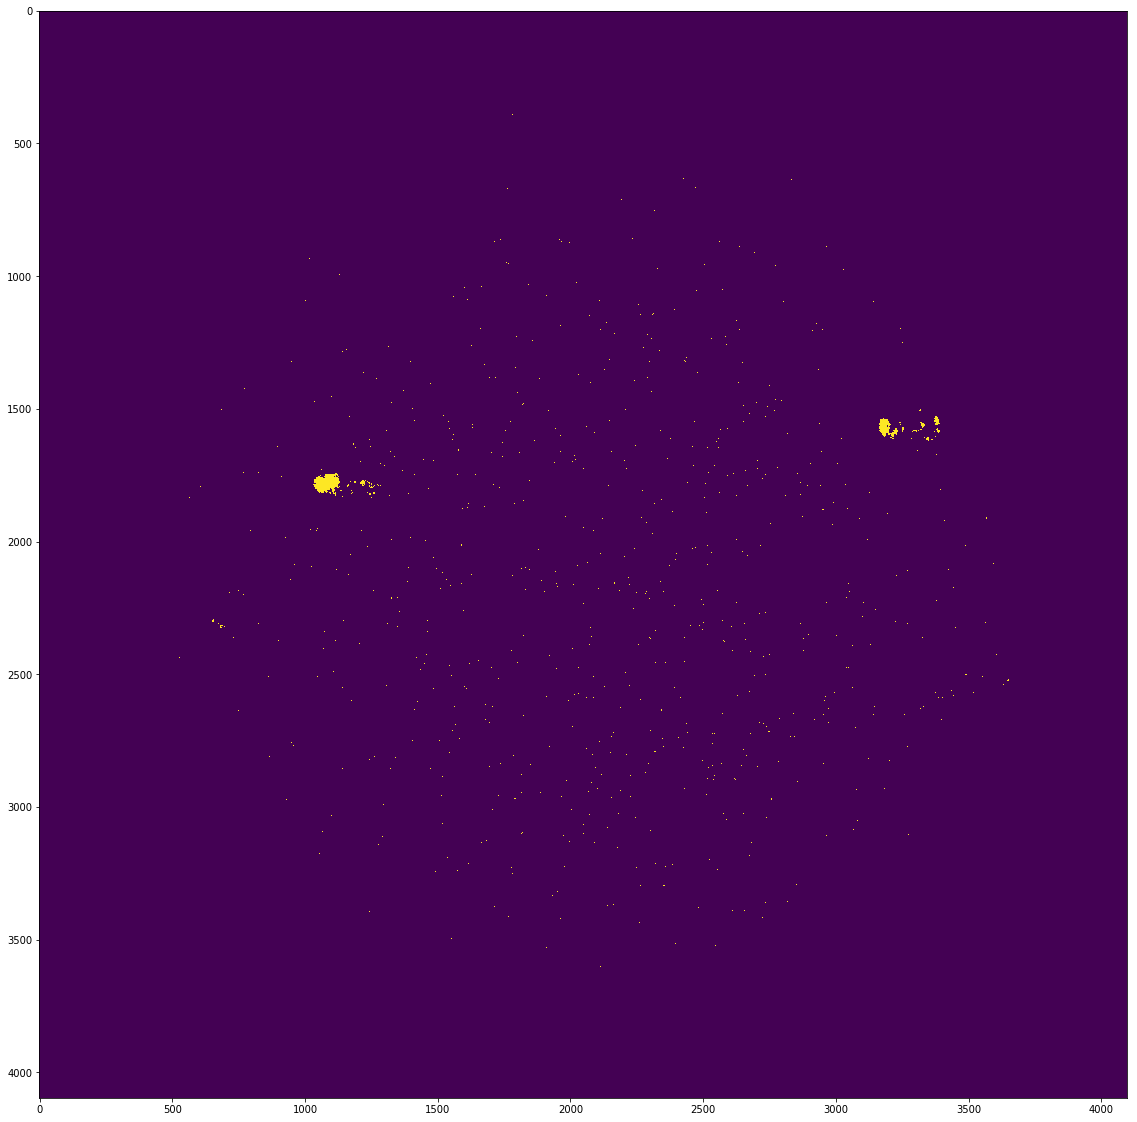

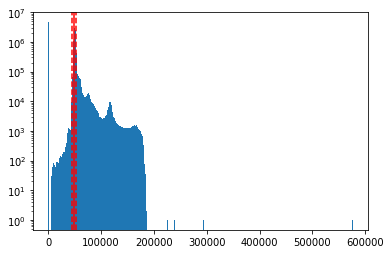

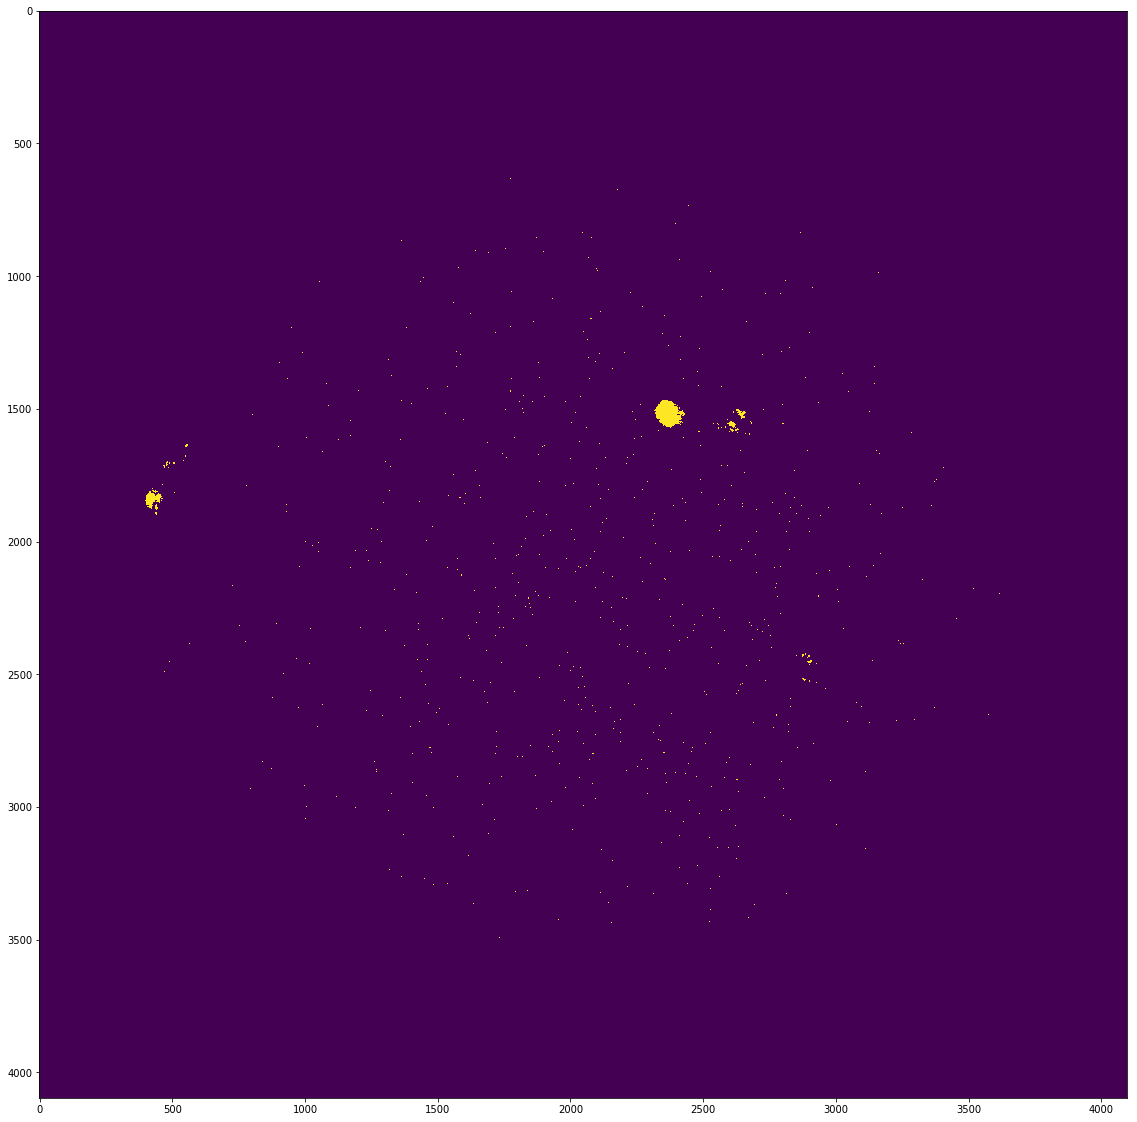

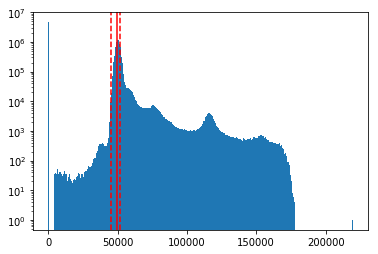

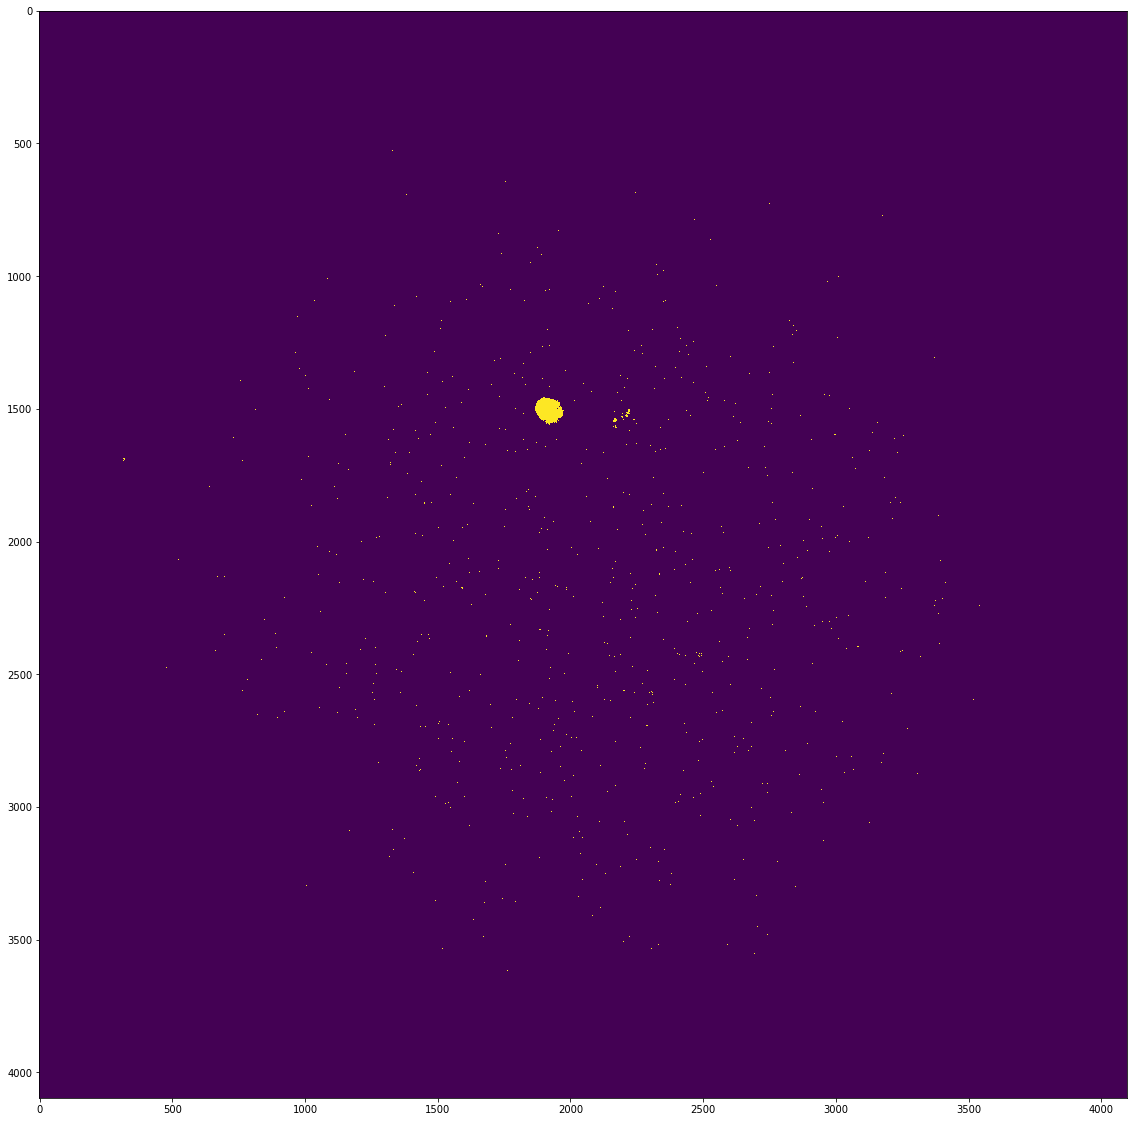

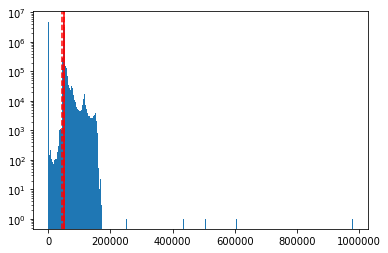

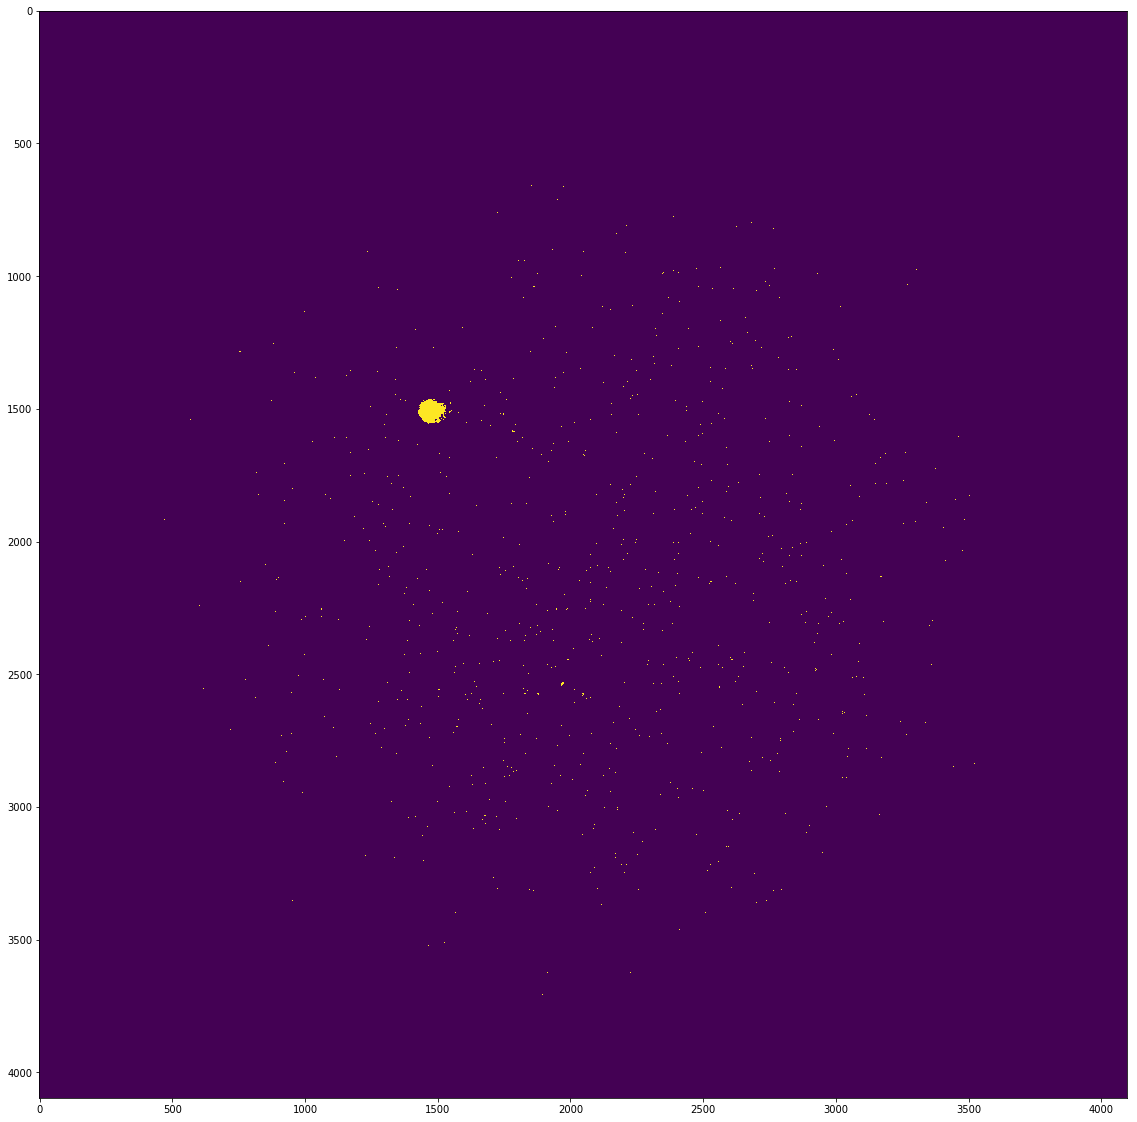

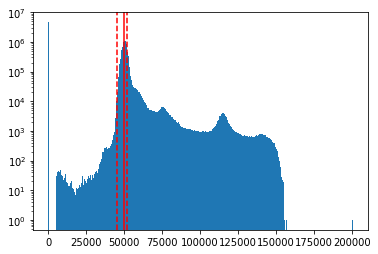

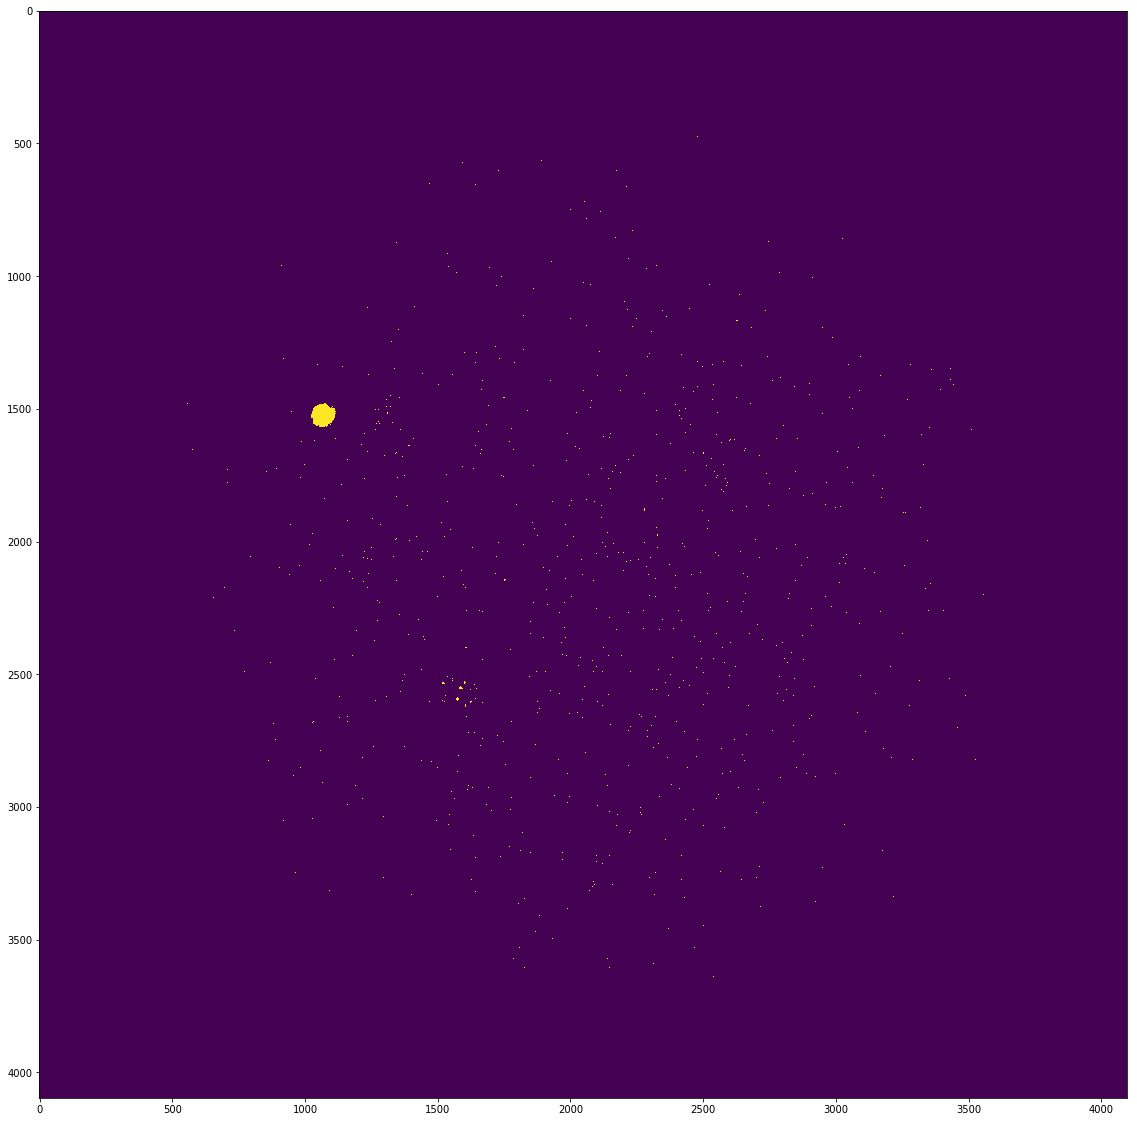

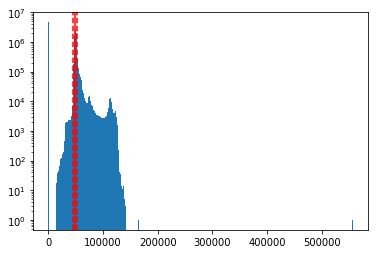

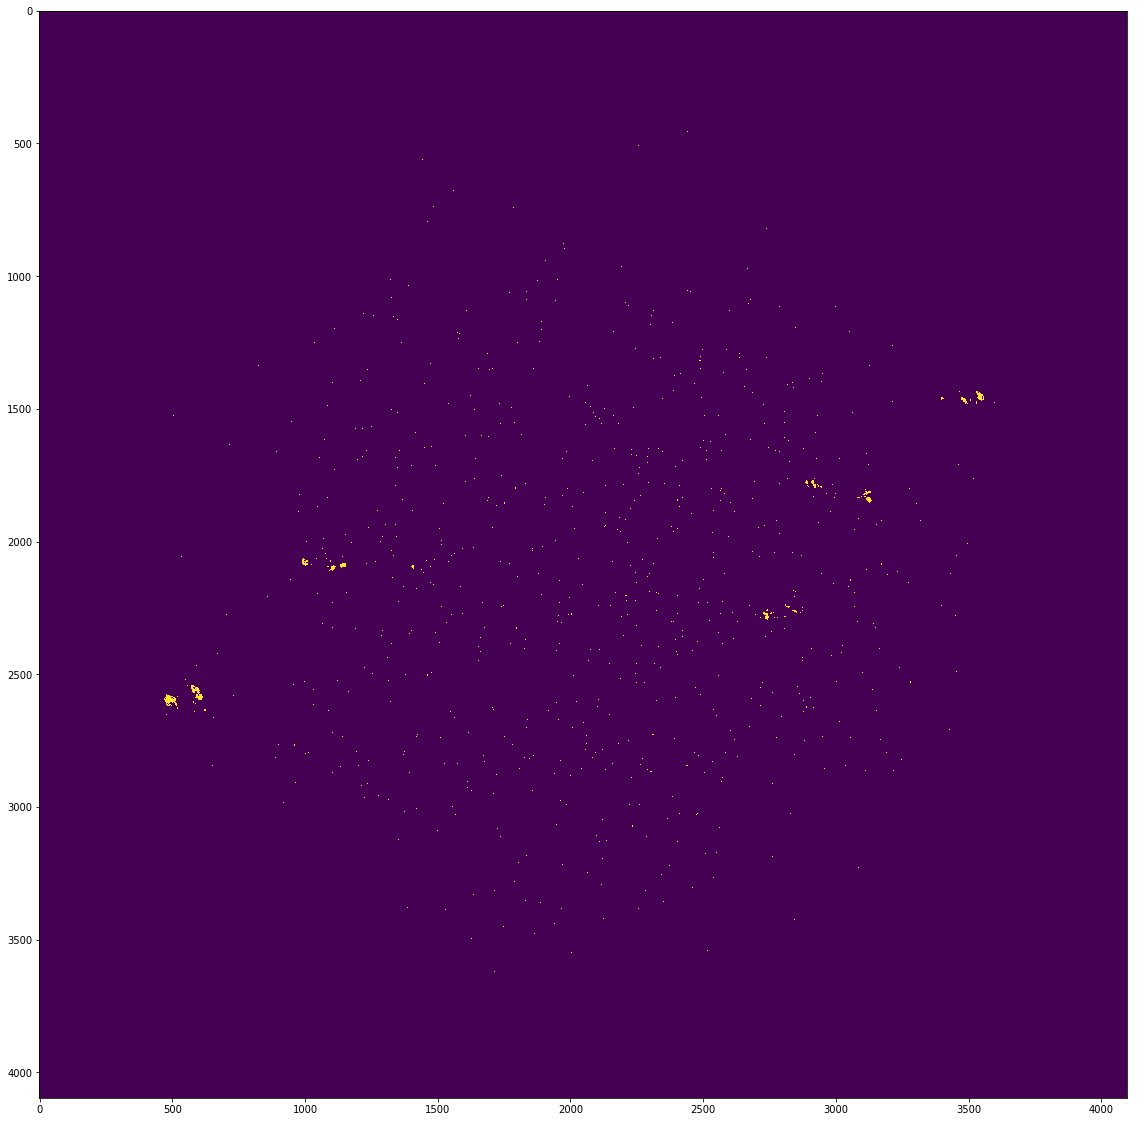

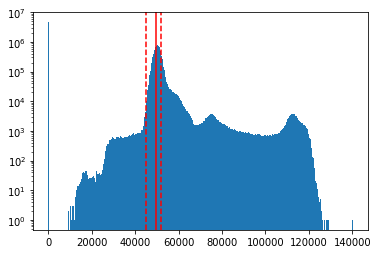

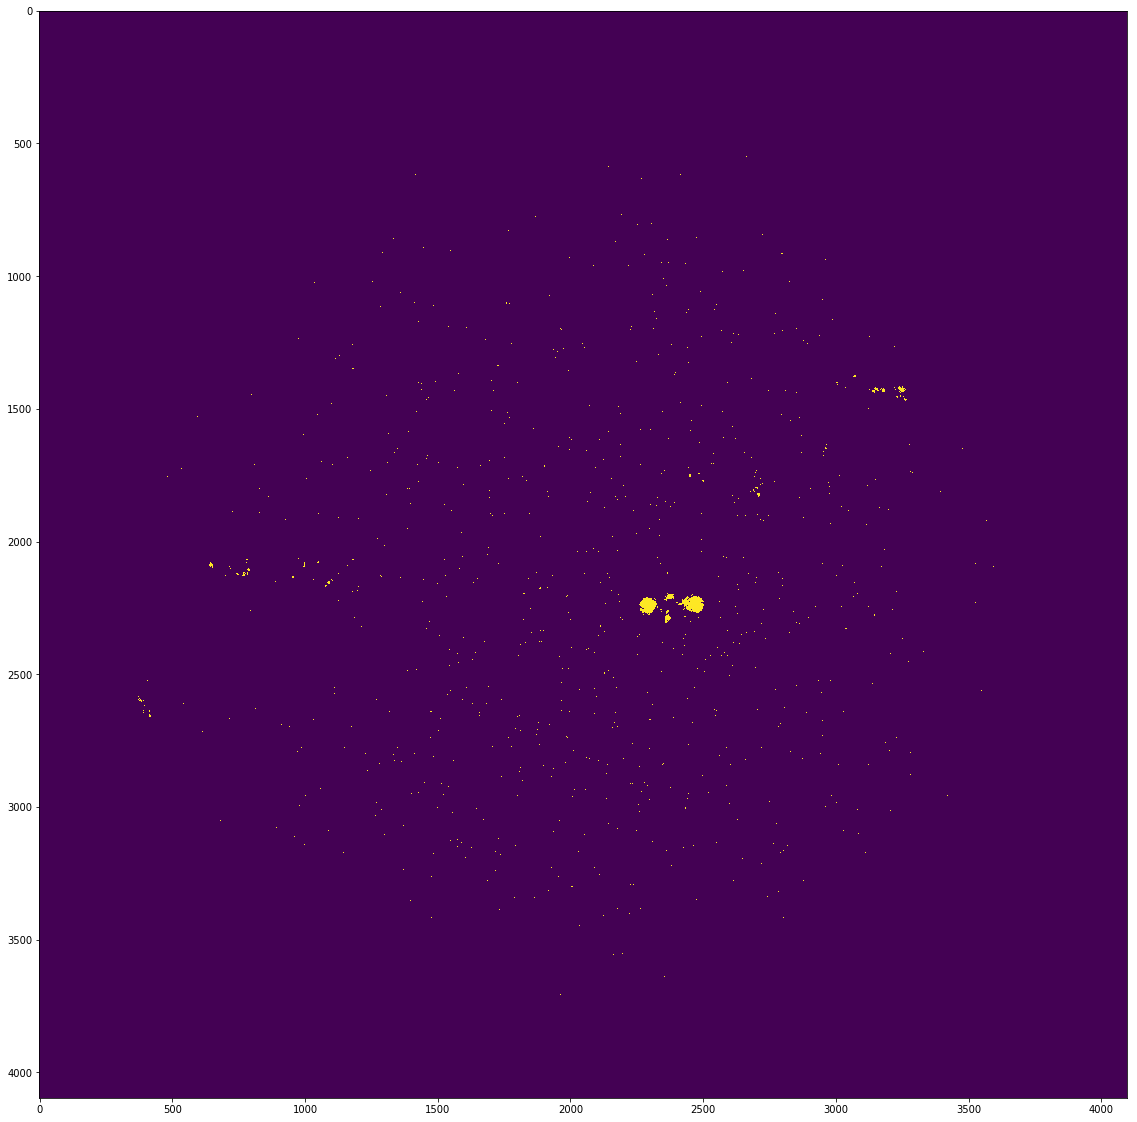

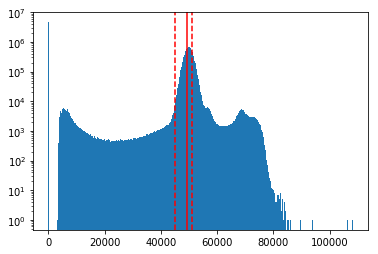

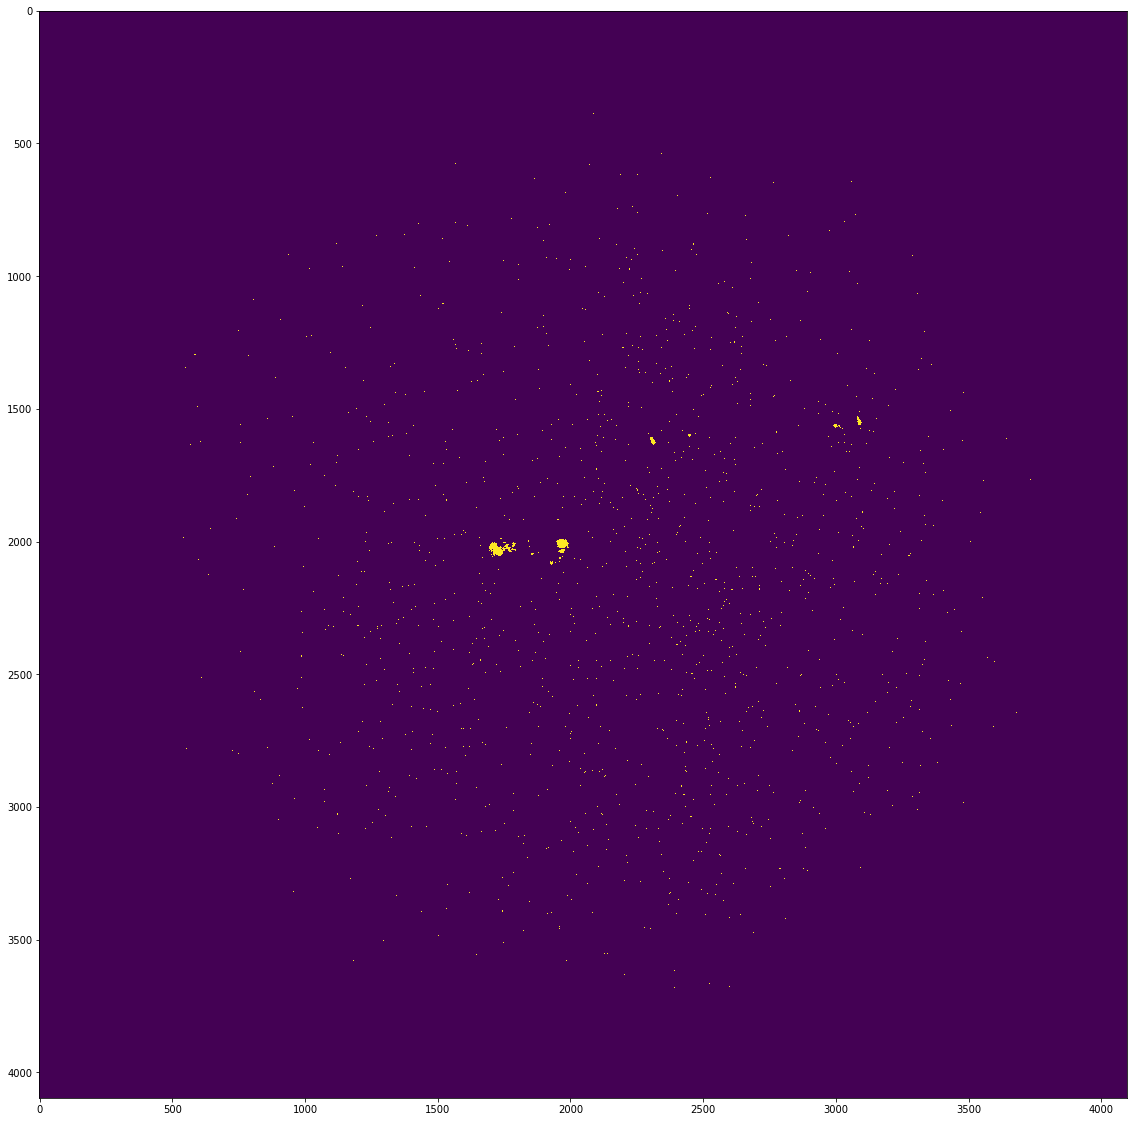

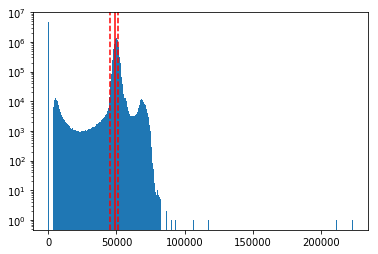

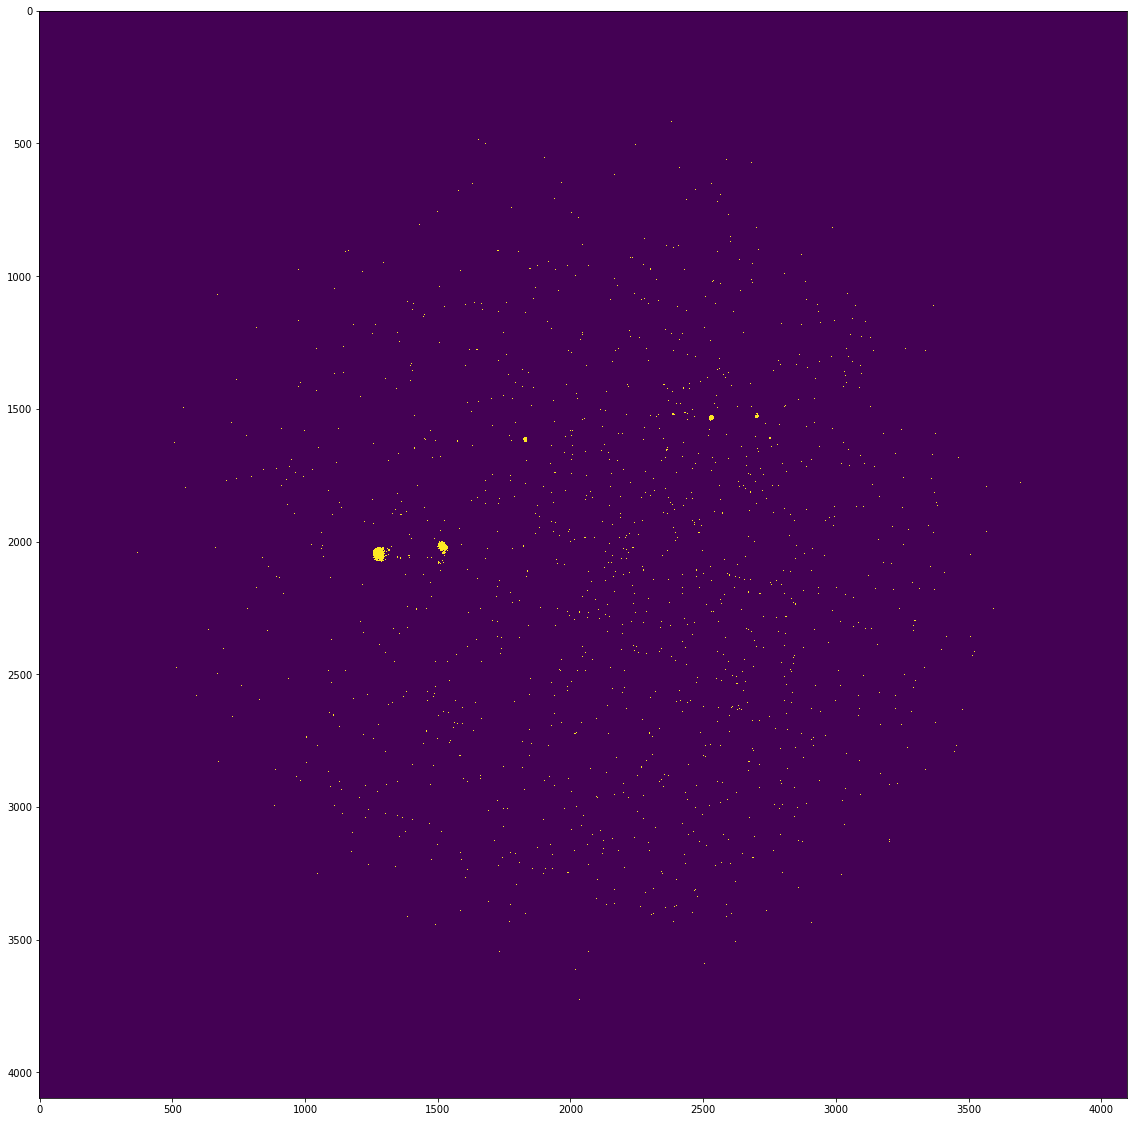

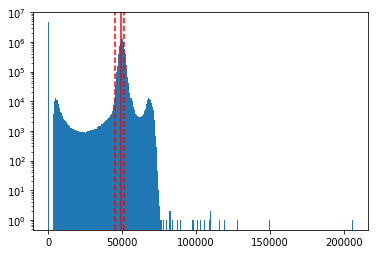

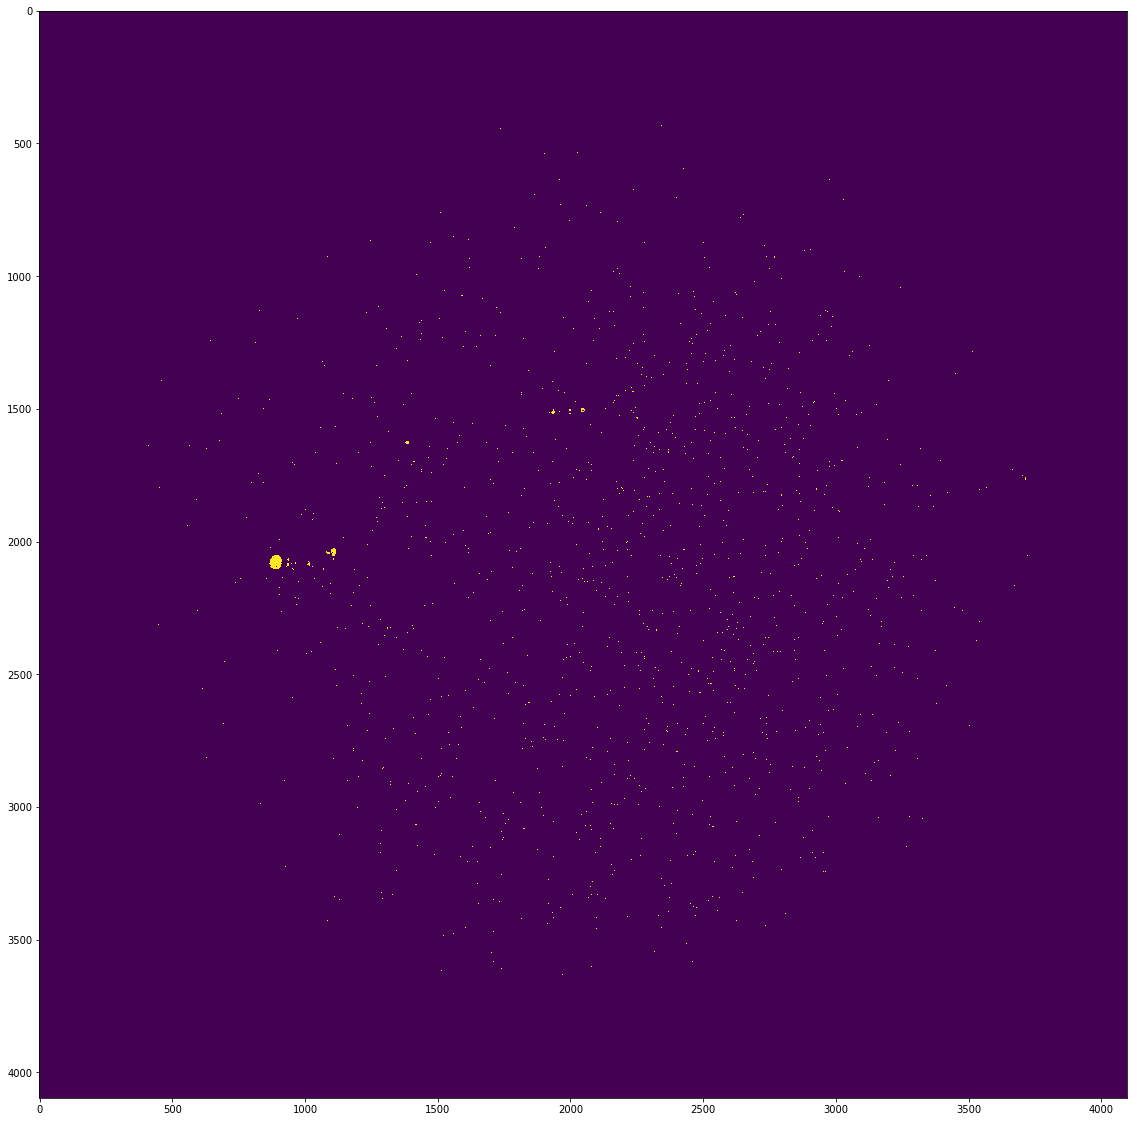

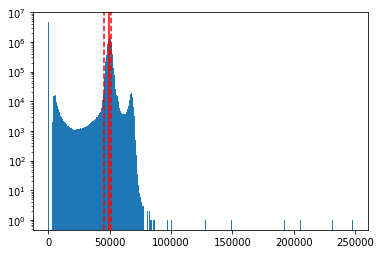

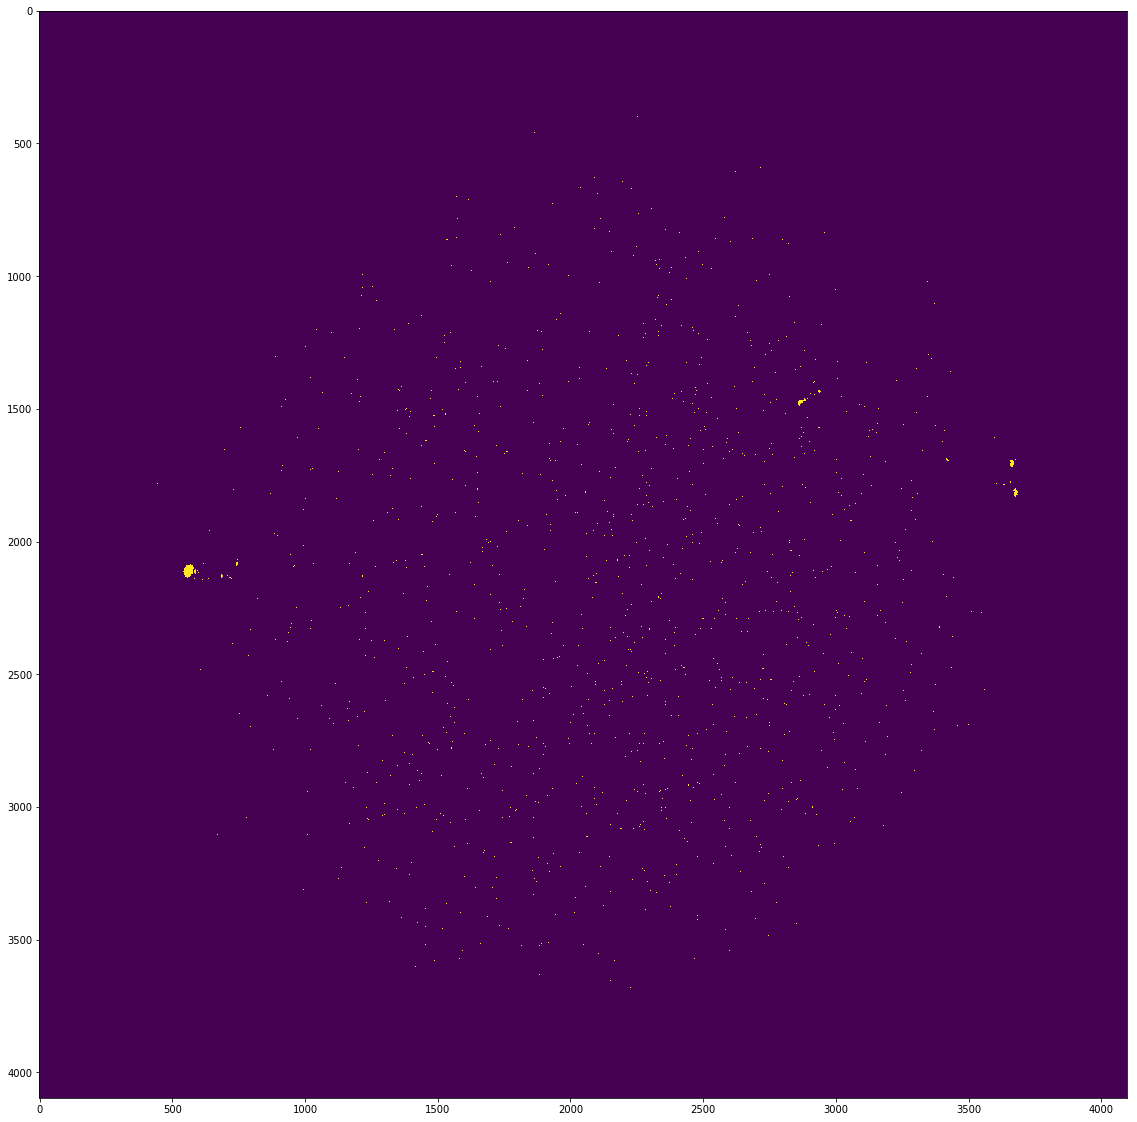

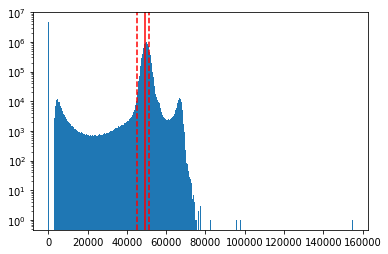

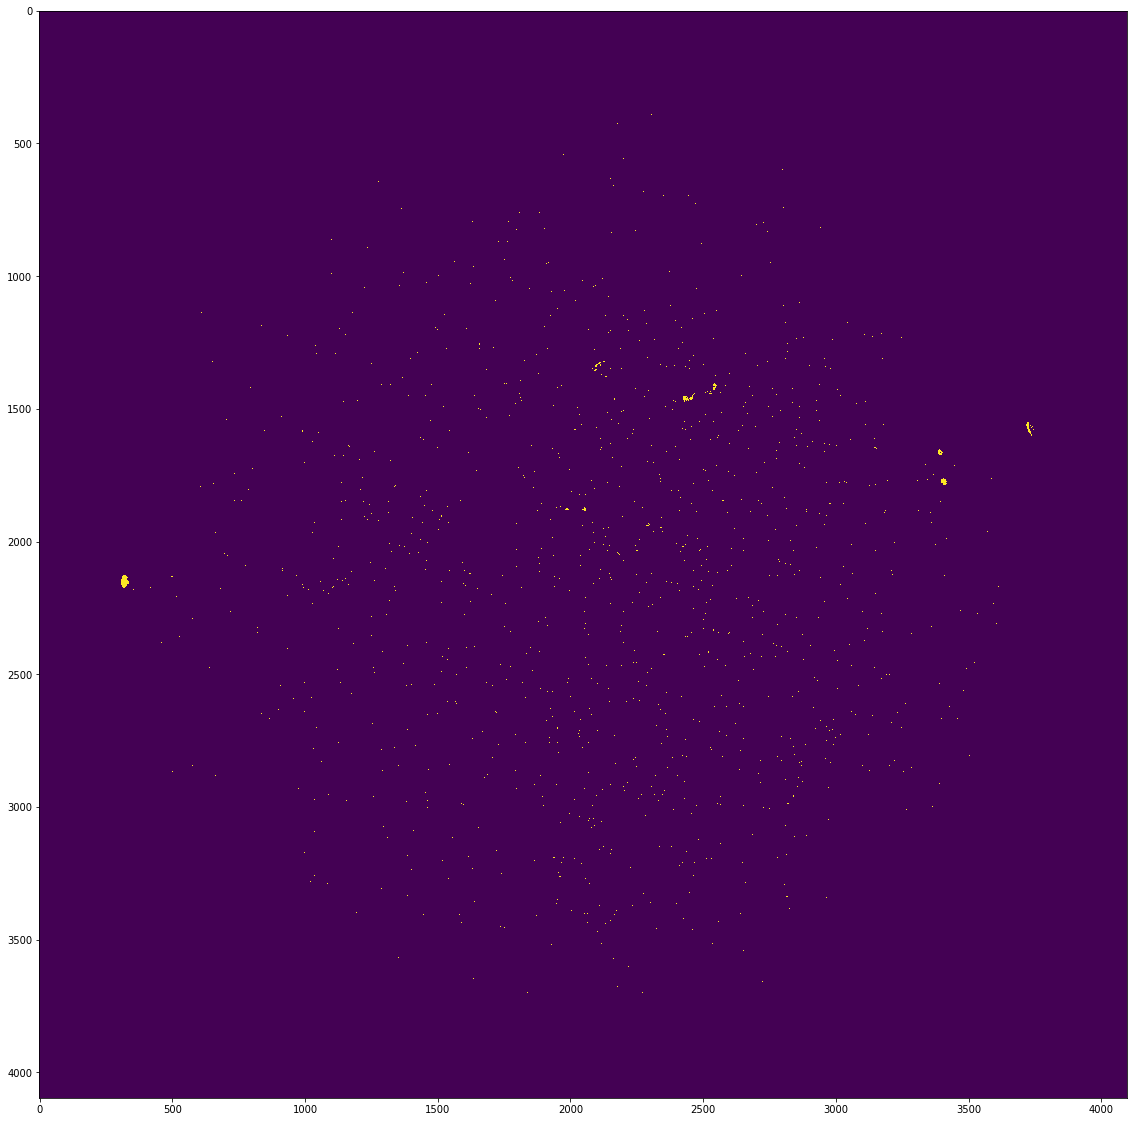

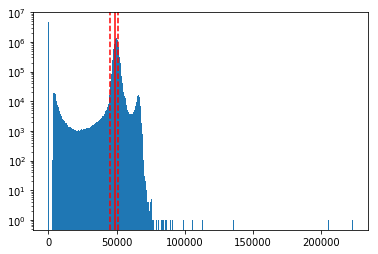

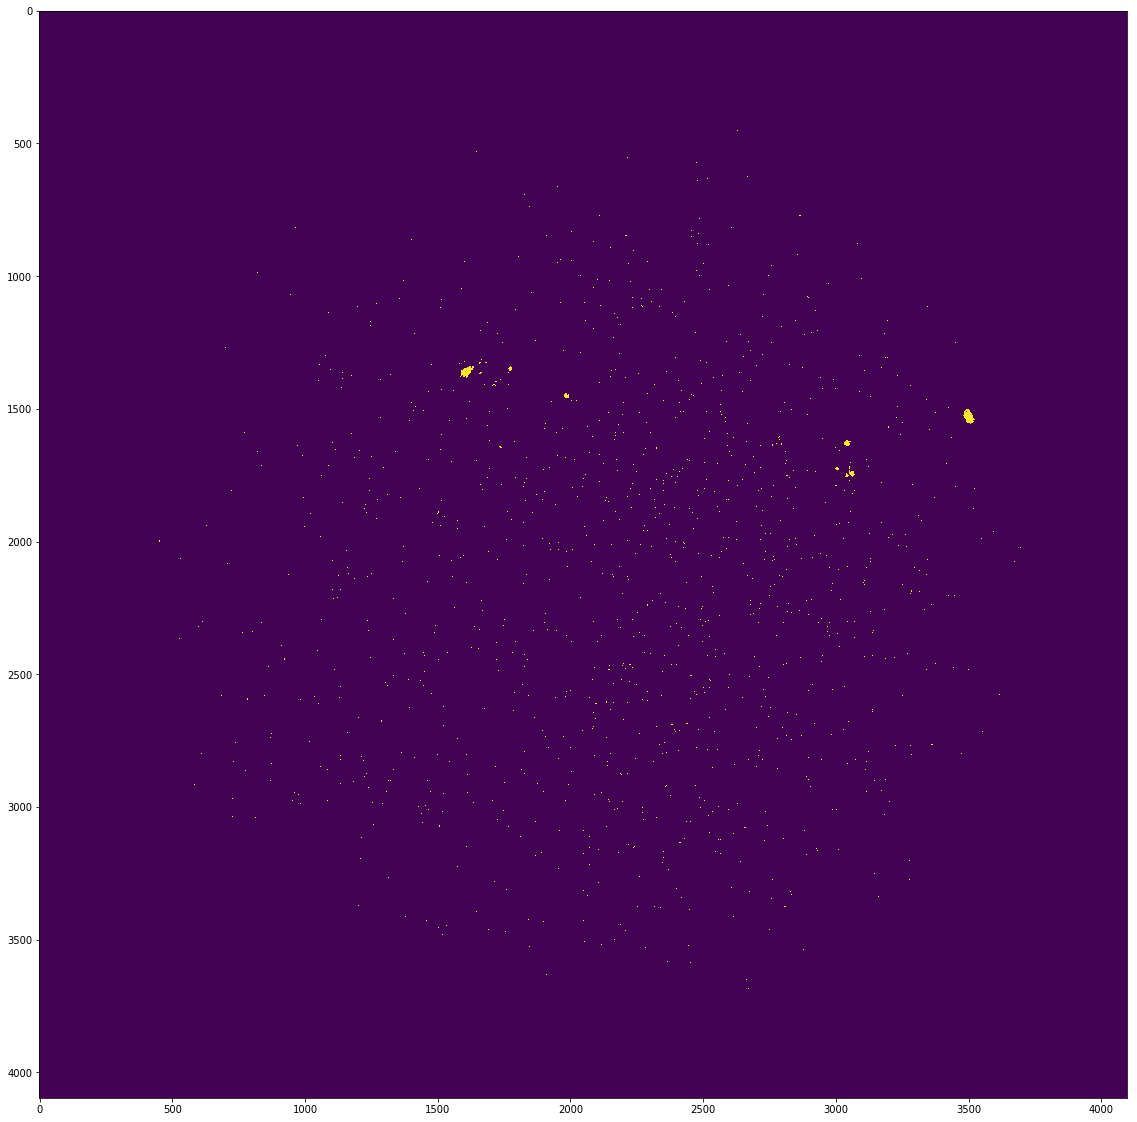

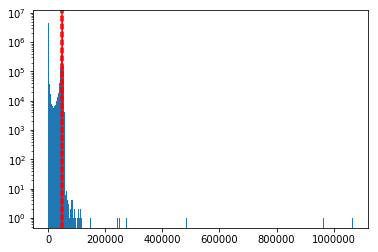

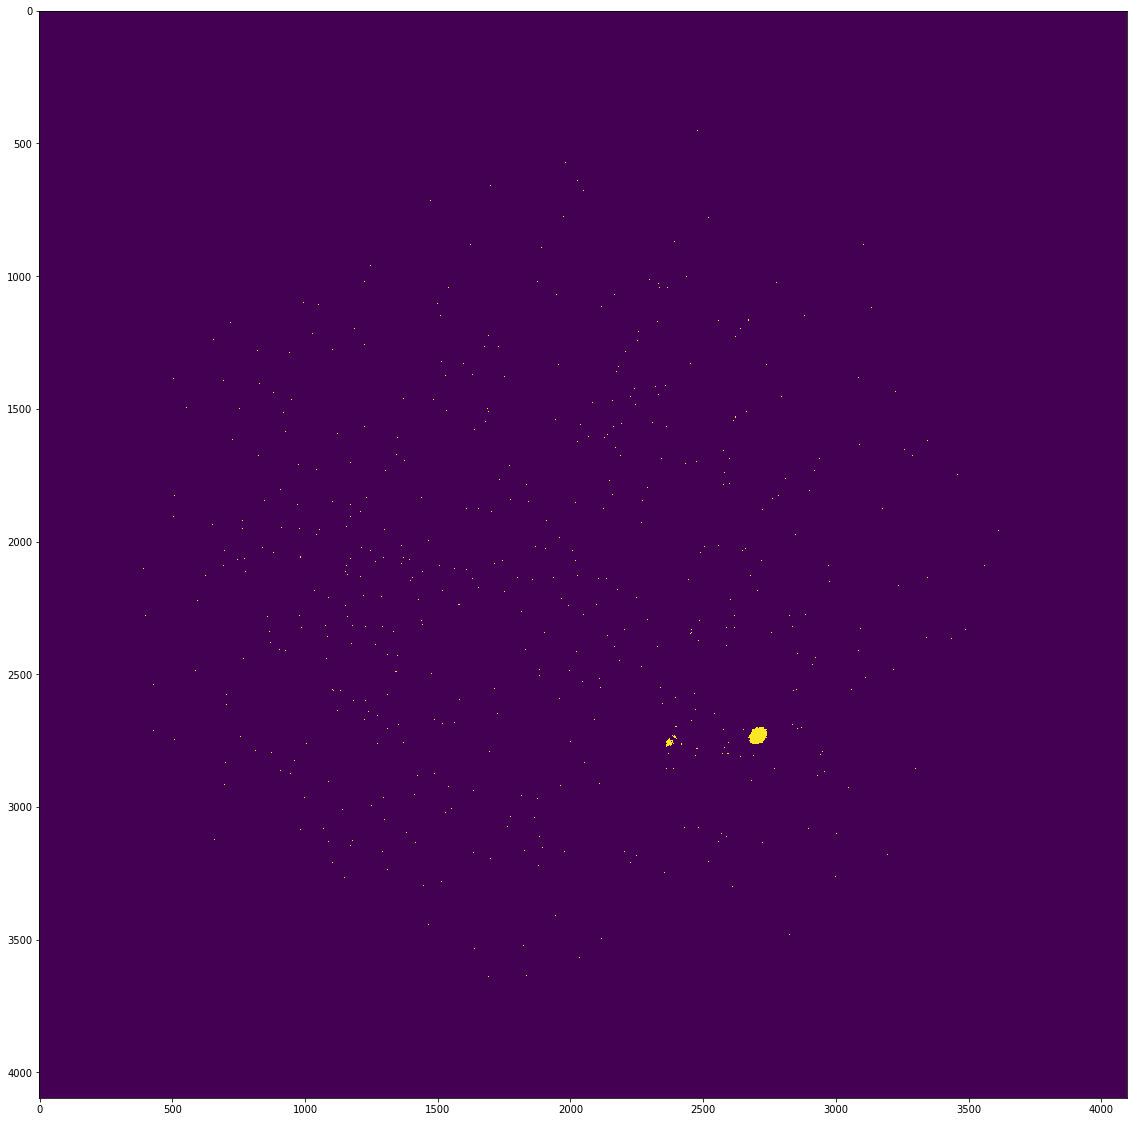

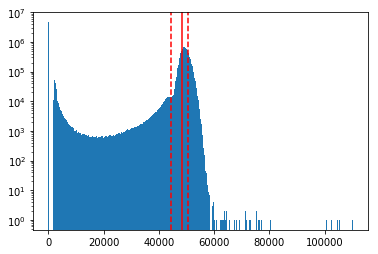

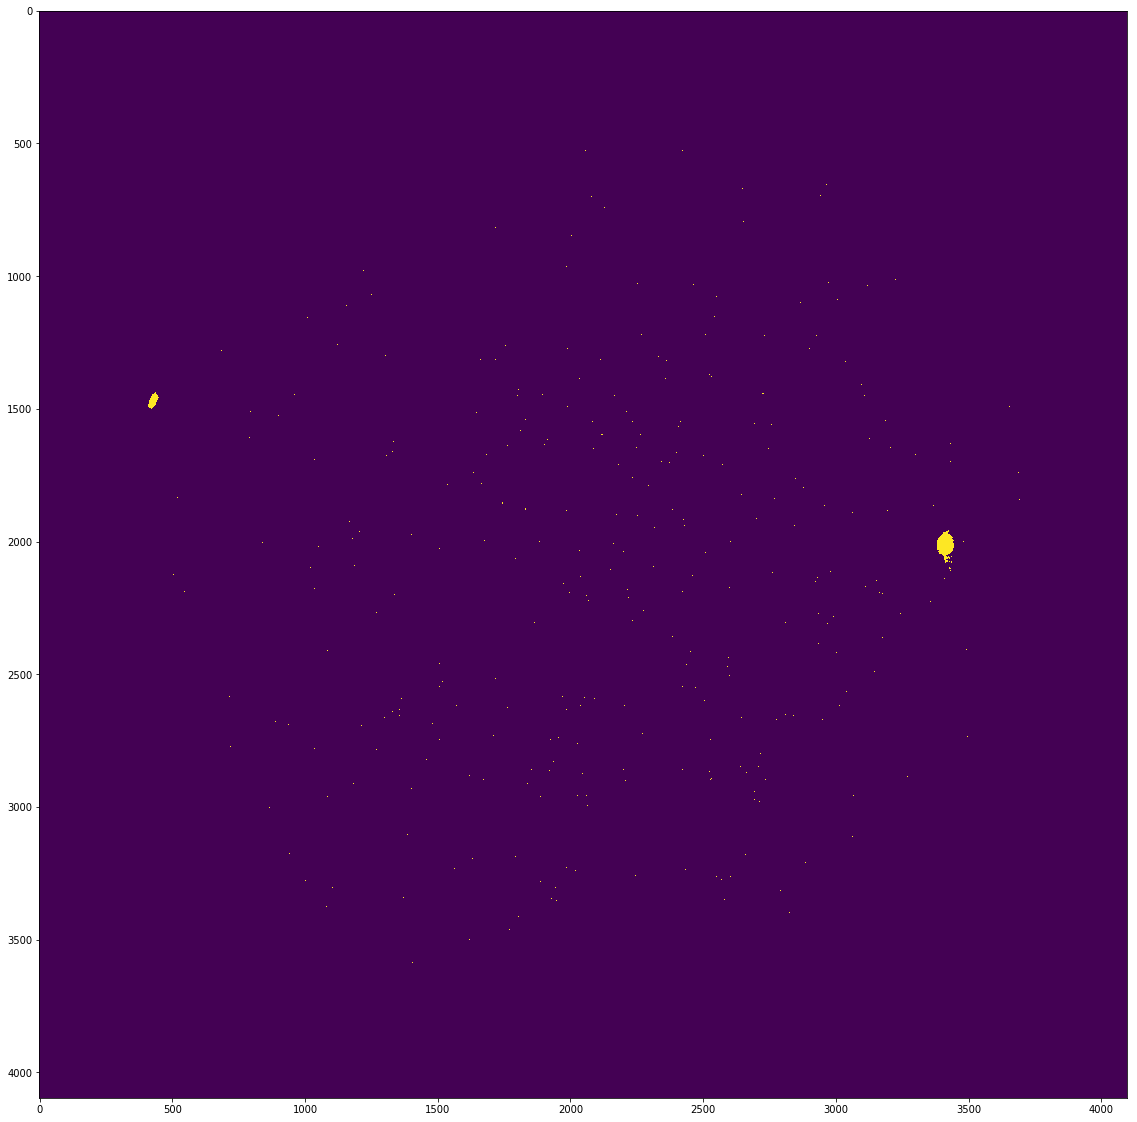

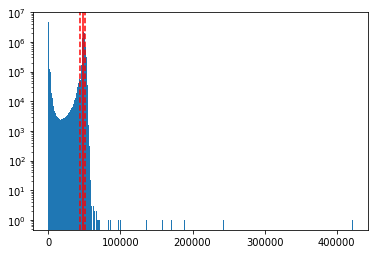

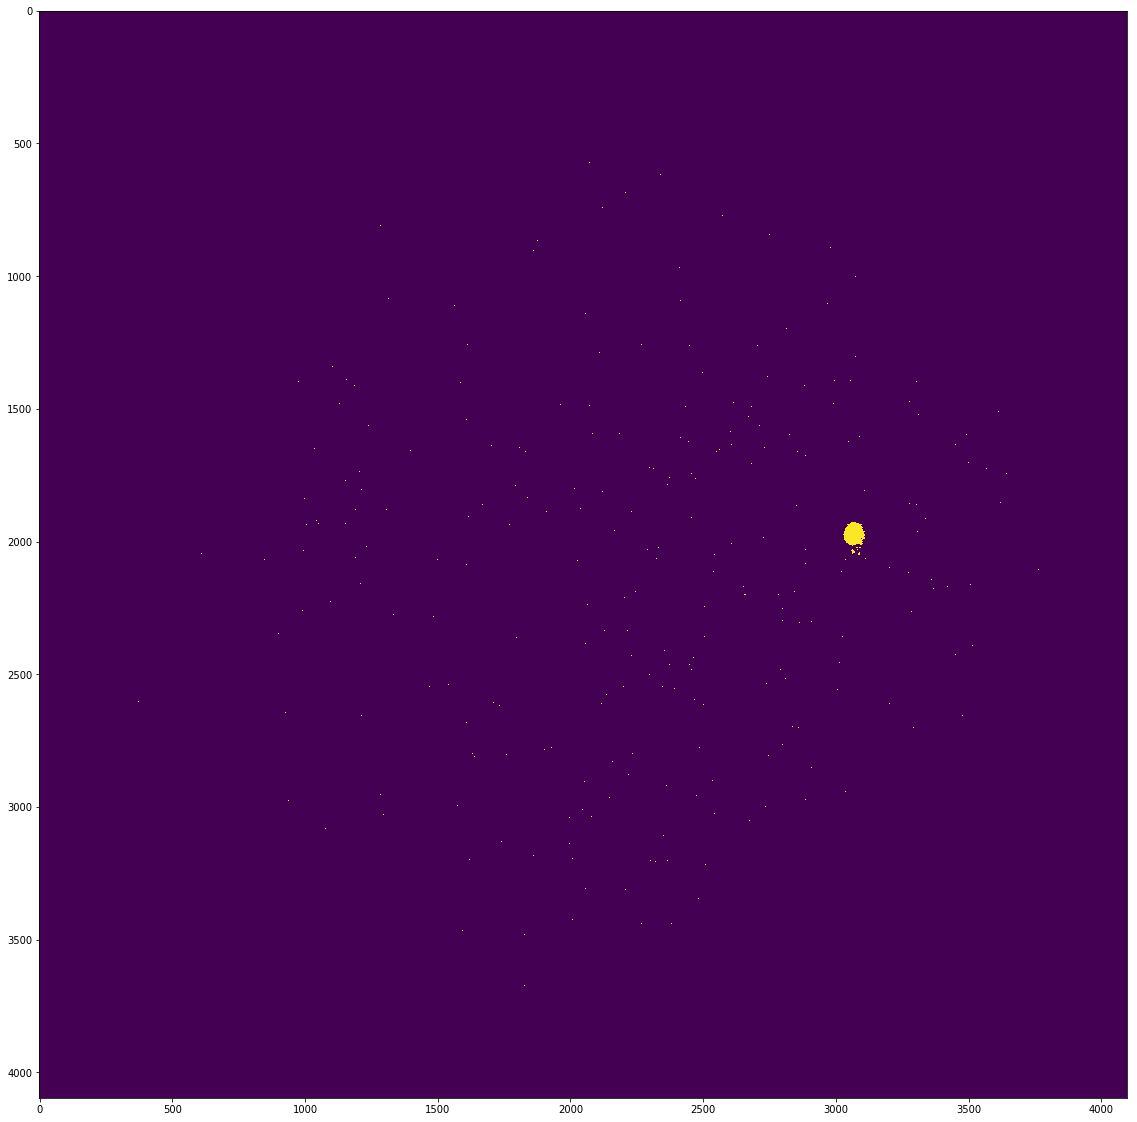

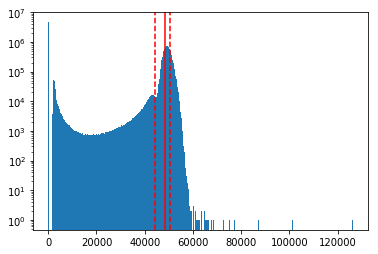

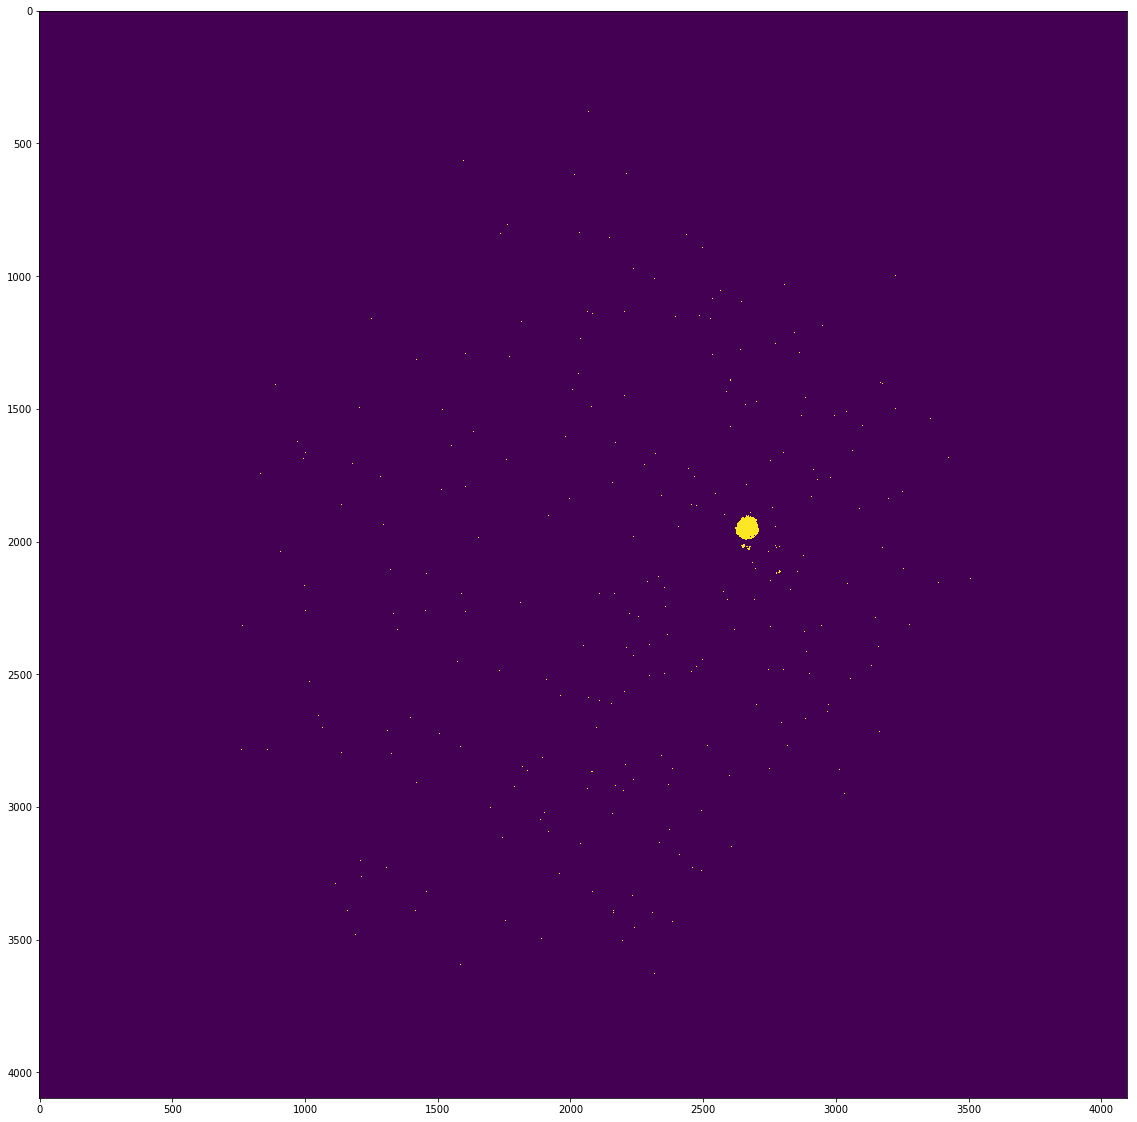

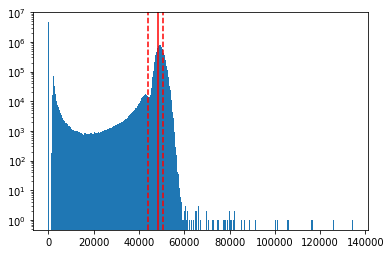

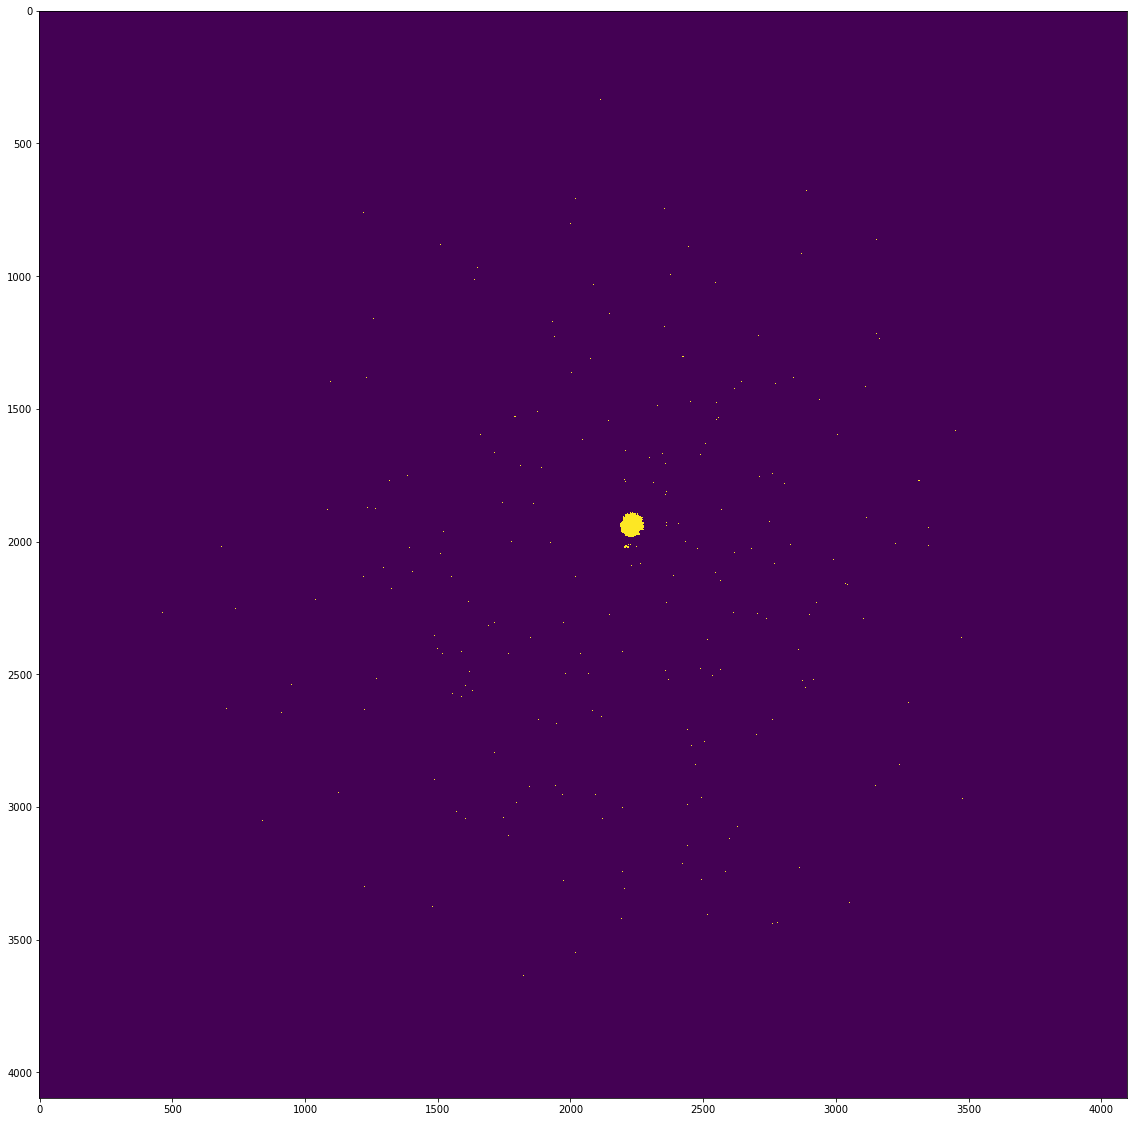

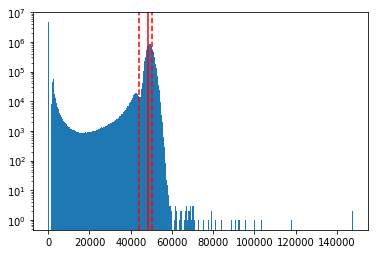

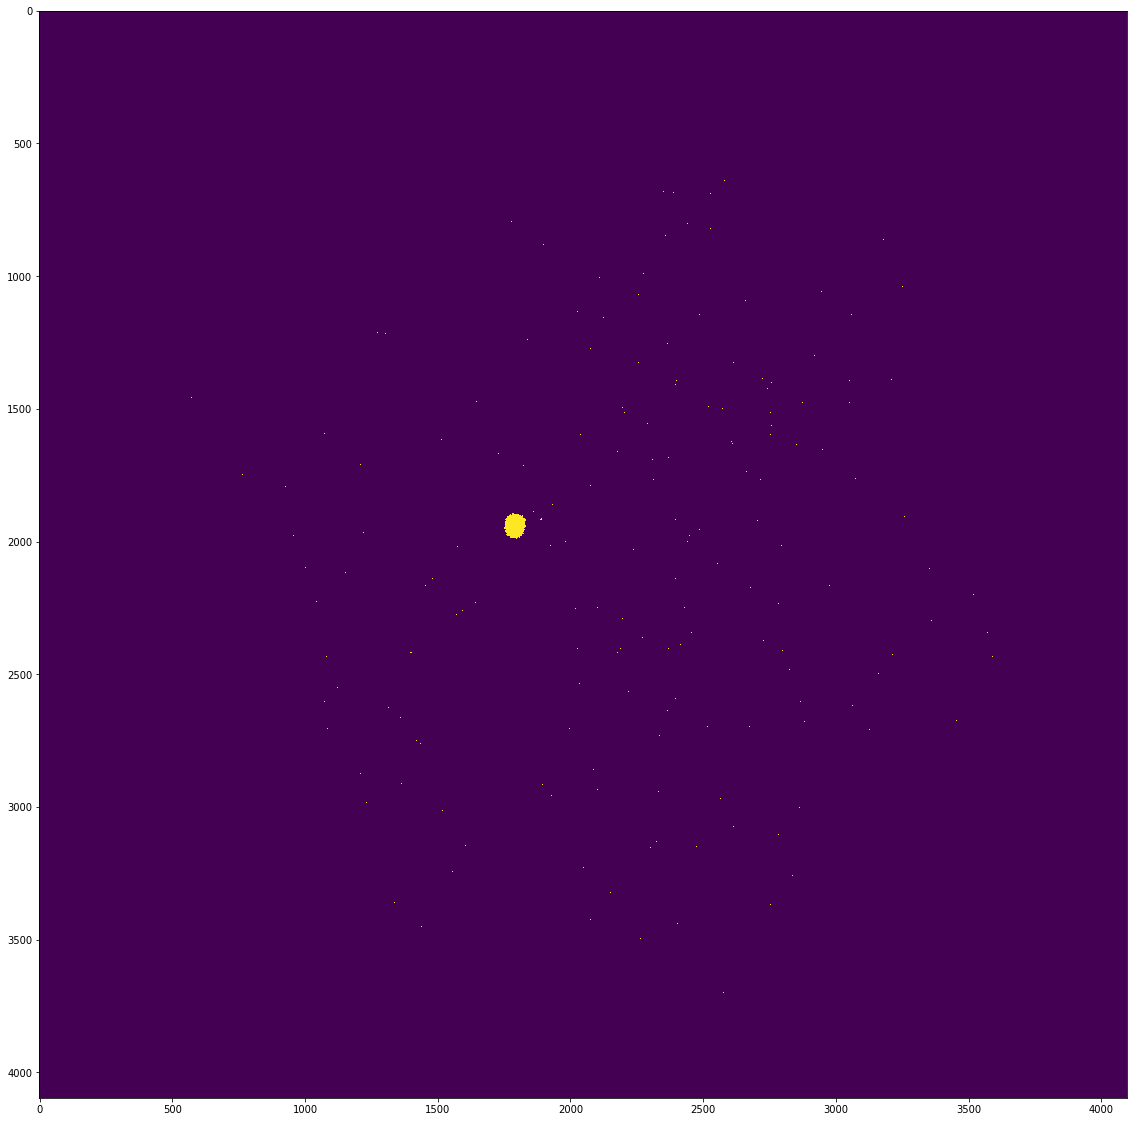

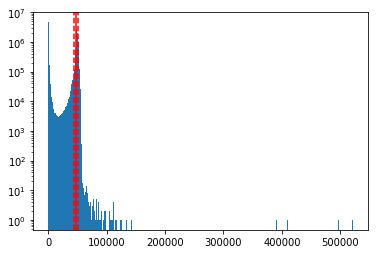

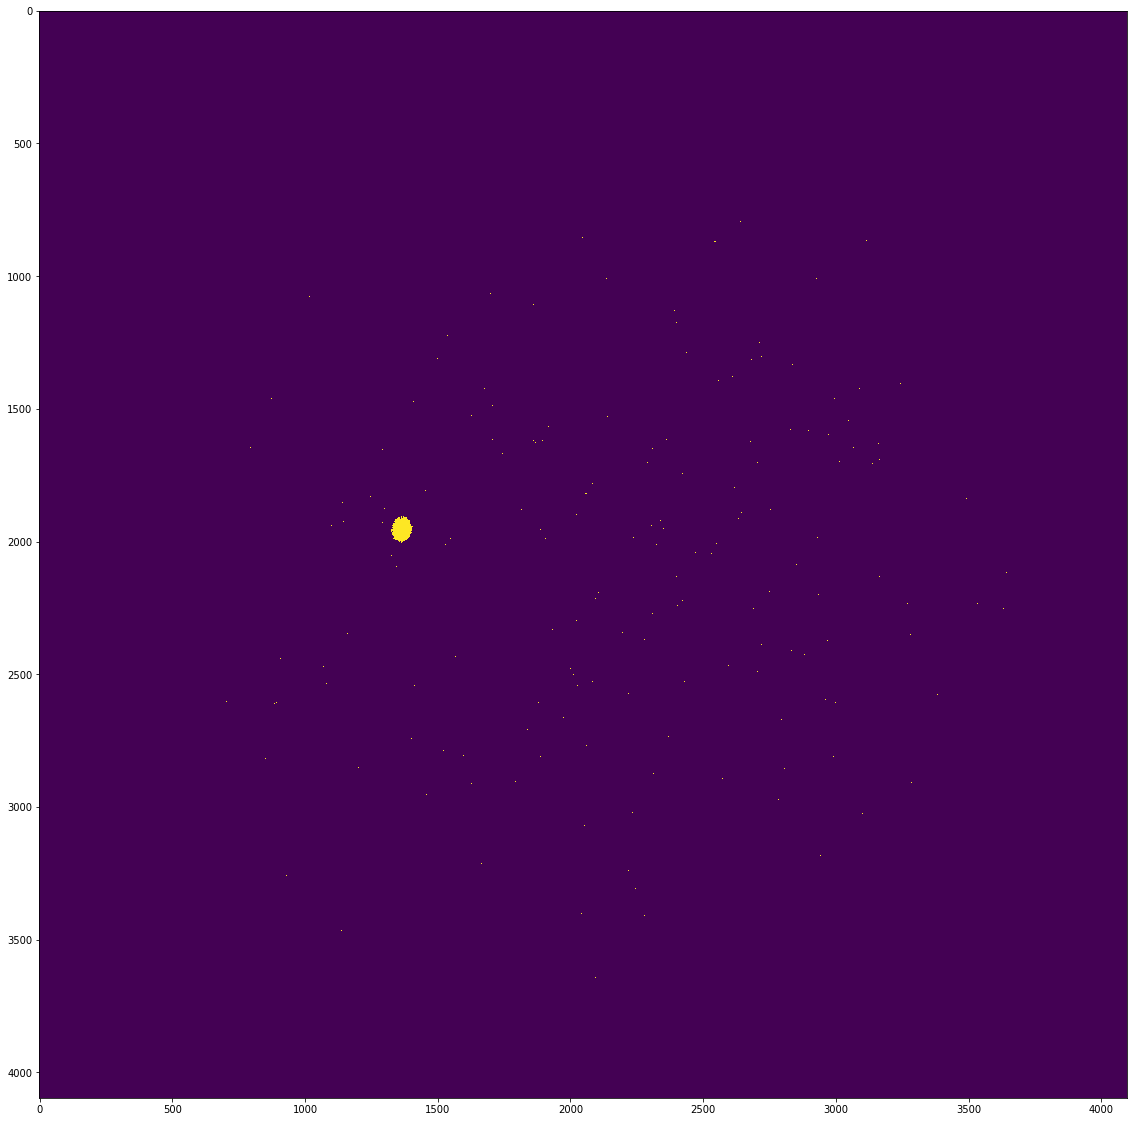

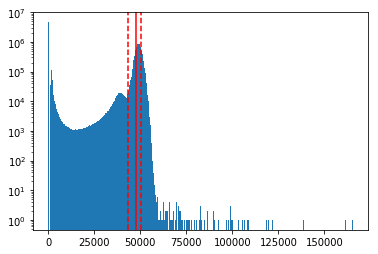

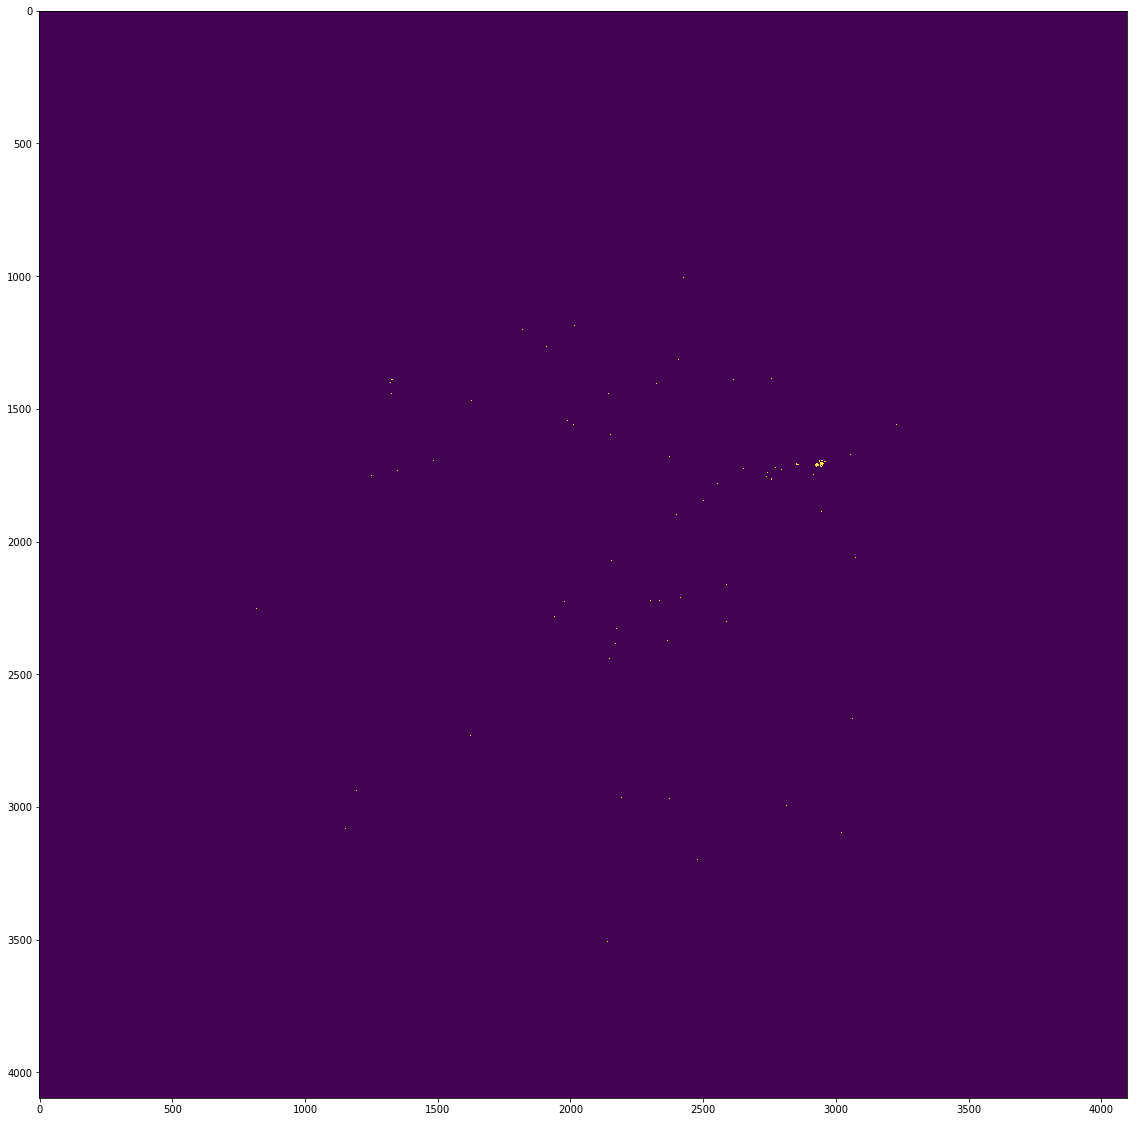

In [51]:
f_S = dict()

for image, day in zip(images, days): 
    flatfielded = (image / normed_image)
    flatfielded[np.isnan(flatfielded)] = 0
    
    plt.hist(flatfielded.ravel(), bins=500, log=True);
    mid, upper = np.percentile(flatfielded, [50, 84])
    lower = mid - 2*(upper - mid)
    plt.axvline(lower, color='r', ls='--')
    plt.axvline(mid, color='r')
    plt.axvline(upper, ls='--', color='r')
    plt.show()
    
    # from skimage.filters import threshold_yen
    fig, ax = plt.subplots(figsize=(20, 20))
    spot_mask = (flatfielded < lower) * (on_sun_mask)
    ax.imshow(spot_mask)
    plt.show()
    spotted_fraction = np.count_nonzero(spot_mask) / np.count_nonzero(on_sun_mask)
    
    f_S[str(day)] = spotted_fraction

In [55]:
from json import dump 

dump(f_S, open("f_S.json", 'w'))